Task 3: Pre-trained state-of-the-art architecture
- development of a classification model for discriminating between subclasses of each parent class.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import timeit
import datetime
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.regularizers import l2, l1
from sklearn import metrics
from pathlib import Path
import pandas as pd
import random as rn
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.python.framework import ops
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory


os.environ["PYTHONHASHSEED"]="0"
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

#magic command for enabling tensorflow 1.x
#%tensorflow_version 1.x 

# print tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [3]:
# Tensorflow is already installed in Colab
# check if tensorflow is installed
import tensorflow as tf
print(tf.__version__) 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('you must enable GPU! Go to:')
  print('\nRuntime')
  print('\tChange runtime type')
  print('\t\tHardware Accelerator: GPU')

  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.7.0
Found GPU at: /device:GPU:0


In [4]:
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224 
BATCH_SIZE = 32
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
PATH_DATASET_PREPROCESSED = '/content/drive/Shareddrives/CIDL/dataset/preprocessed'


In [5]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2), 
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant", fill_value=255),
    layers.RandomZoom(0.1, fill_mode="nearest") 
  ]
)

In [6]:
def conversion_batch_to_narray(dataset):
  lista = np.array([])
  labels_set = np.array([])
  i=0
  for elem,elem2 in dataset.as_numpy_iterator():
    print(elem.shape)
    if(i==0):
      lista = elem
    else:
      lista =  np.append(lista,elem,axis=0)
    i=i+1
    labels_set = np.append(labels_set,elem2,axis=0)
    print(lista.shape)
    print(i)
    if(i==-1):
      break
  return lista, labels_set


In [7]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [8]:
def get_training_learning_dataframes(df_dataset,numberTests = 5):

  df_unique_labels = df_dataset.copy().drop_duplicates(subset=["Label"]).reset_index()
  list_labels = df_unique_labels["Label"].tolist()


  df_test = pd.DataFrame(columns=['Filepath','Label'])
  df_training = pd.DataFrame(columns=['Filepath','Label'])
  cum_indices = []

  for etichetta in list_labels:
    list_indices = df_dataset[(df_dataset.Label==etichetta)].index
    indices = [ list_indices[j] for j in range(numberTests)] #get only the first 'numberTests' indices of a set of samples for a specific class


    for elem in indices:
      cum_indices.append(elem)

    df_tmp = pd.DataFrame(df_dataset.iloc[indices])
    df_test = pd.concat([df_test,df_tmp],ignore_index = True, axis = 0)


  cum_indices.sort()

  df_training = df_dataset.iloc[~df_dataset.index.isin(cum_indices)] 
  df_training.reset_index(drop=True, inplace=True)

  return df_training,df_test

In [9]:
def convert_codification_int_to_names(y_pred,dataset):
  #[28,22,30] -> ['spinach','peas','tomato']

  labels = (dataset.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  y_pred_names = []
  for elem in y_pred:
    y_pred_names.append(labels[elem])

  return y_pred_names

In [10]:
 def get_array_names_test_pred(pred,test_dataset):

  labels = (test_dataset.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  y_pred_names = [labels[k] for k in pred]
  y_test_names = [labels[k] for k in test_dataset.classes]

  return y_test_names,y_pred_names

In [11]:
# Create a list with the filepaths for training and testing
dataset_dir_multiclass = Path(PATH_DATASET_PREPROCESSED)
dataset_filepaths = list(dataset_dir_multiclass.glob(r'**/*.jpg'))


df_dataset = proc_img(dataset_filepaths)
_,df_test_multiclass = get_training_learning_dataframes(df_dataset,10)


In [12]:
test_datagenerator_scratch = ImageDataGenerator(rescale= 1. / 255.0,)
test_datagenerator_pretrained = ImageDataGenerator()


multiclass_scratch_test_images = test_datagenerator_scratch.flow_from_dataframe(
    dataframe=df_test_multiclass,
    x_col='Filepath',
    y_col='Label',
    target_size=(180, 180),
    color_mode='rgb',
    class_mode='categorical',
    seed=0,
    batch_size=1,
    shuffle=False   
)


multiclass_pretrained_test_images = test_datagenerator_pretrained.flow_from_dataframe(
    dataframe=df_test_multiclass,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    seed=0,
    batch_size=1,
    shuffle=False   
)

Found 330 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.


In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

dataset_preprocessed = image_dataset_from_directory(
    os.path.join(PATH_DATASET_PREPROCESSED, ''),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2651 files belonging to 33 classes.


In [14]:
training_preprocessed =image_dataset_from_directory(
    PATH_DATASET_PREPROCESSED,
    validation_split=0.1,
    subset= "training",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    seed = 123,
    batch_size=BATCH_SIZE)


Found 2651 files belonging to 33 classes.
Using 2386 files for training.


In [15]:
test_preprocessed =image_dataset_from_directory(
    PATH_DATASET_PREPROCESSED,
    validation_split=0.1,
    subset= "validation",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    seed = 123,
    batch_size=BATCH_SIZE)


Found 2651 files belonging to 33 classes.
Using 265 files for validation.


In [ ]:
training_set,labels_set = conversion_batch_to_narray(training_preprocessed)

In [ ]:
from tensorflow.keras.utils import to_categorical
labels_set_hot = to_categorical(labels_set)

In [16]:
test_set, test_labels = conversion_batch_to_narray(test_preprocessed)

(32, 224, 224, 3)
(32, 224, 224, 3)
1
(32, 224, 224, 3)
(64, 224, 224, 3)
2
(32, 224, 224, 3)
(96, 224, 224, 3)
3
(32, 224, 224, 3)
(128, 224, 224, 3)
4
(32, 224, 224, 3)
(160, 224, 224, 3)
5
(32, 224, 224, 3)
(192, 224, 224, 3)
6
(32, 224, 224, 3)
(224, 224, 224, 3)
7
(32, 224, 224, 3)
(256, 224, 224, 3)
8
(9, 224, 224, 3)
(265, 224, 224, 3)
9


In [17]:
from tensorflow.keras.utils import to_categorical
test_labels_hot = to_categorical(test_labels)

#Training

##VGG16


In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

###Model_1_Base

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_1_VGG16 = keras.Model(inputs, outputs)
model_1_VGG16.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_VGG16_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 91.1621 - accuracy: 0.5892
Epoch 00001: val_loss improved from inf to 122.45747, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_VGG16_feature_extraction.h5
68/68 [==============================] - 47s 411ms/step - loss: 91.1621 - accuracy: 0.5892 - val_loss: 122.4575 - val_accuracy: 0.5146
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 16.2679 - accuracy: 0.8975
Epoch 00002: val_loss improved from 122.45747 to 59.64846, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_VGG16_feature_extraction.h5
68/68 [==============================] - 20s 301ms/step - loss: 16.2679 - accuracy: 0.8975 - val_loss: 59.6485 - val_accuracy: 0.7238
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 11.4270 - accuracy: 0.9348
Epoch 00003: val_loss did not improve from 59.64846
68/68 [==============================] - 19s 278ms/st

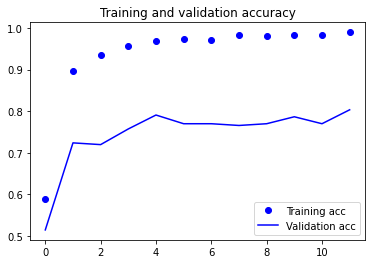

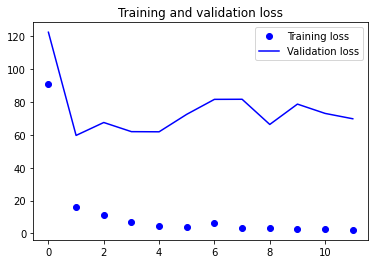

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 6s 665ms/step - loss: 80.7133 - accuracy: 0.7623


0.7622641324996948

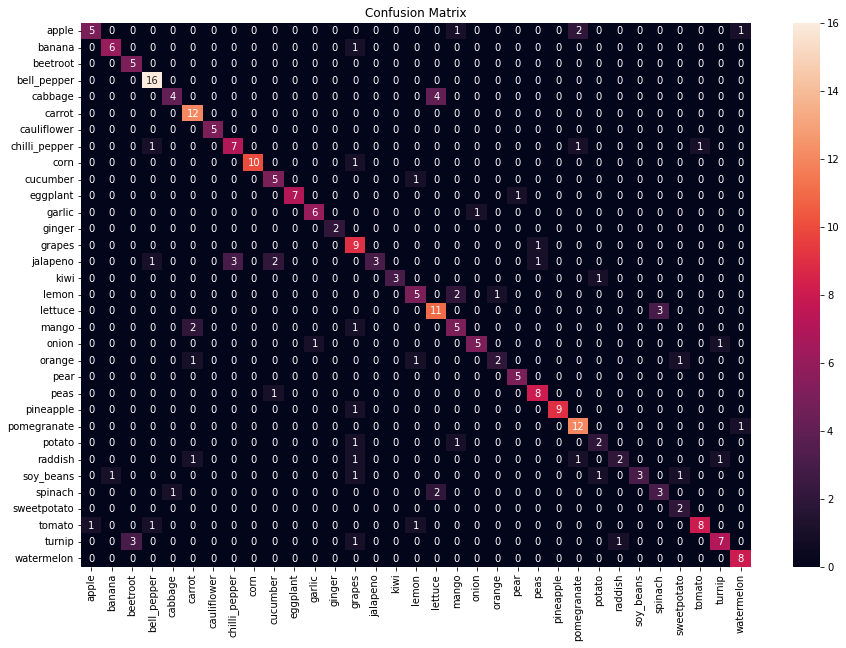

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_VGG16_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 2.6523 - accuracy: 0.9888
Epoch 00001: val_loss improved from inf to 65.35368, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_VGG16_Fine_tuning.h5
68/68 [==============================] - 19s 287ms/step - loss: 2.6523 - accuracy: 0.9888 - val_loss: 65.3537 - val_accuracy: 0.8117
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 1.3801 - accuracy: 0.9884
Epoch 00002: val_loss did not improve from 65.35368
68/68 [==============================] - 19s 278ms/step - loss: 1.3801 - accuracy: 0.9884 - val_loss: 70.9619 - val_accuracy: 0.7782
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 1.5064 - accuracy: 0.9921
Epoch 00003: val_loss did not improve from 65.35368
68/68 [==============================] - 19s 276ms/step - loss: 1.5064 - accuracy: 0.9921 - val_loss: 82.6562 - val_accuracy: 0.7741
Epoch 4/50
68/68 [==============================] - ETA

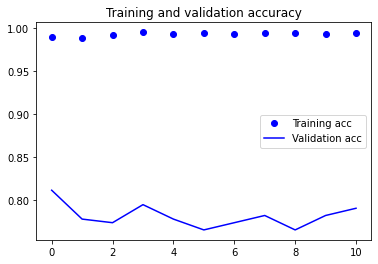

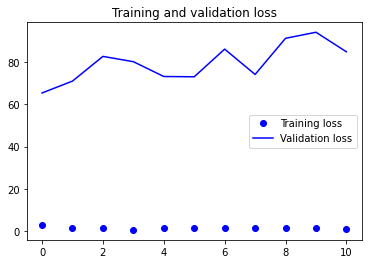

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 232ms/step - loss: 101.1010 - accuracy: 0.7472


0.7471697926521301

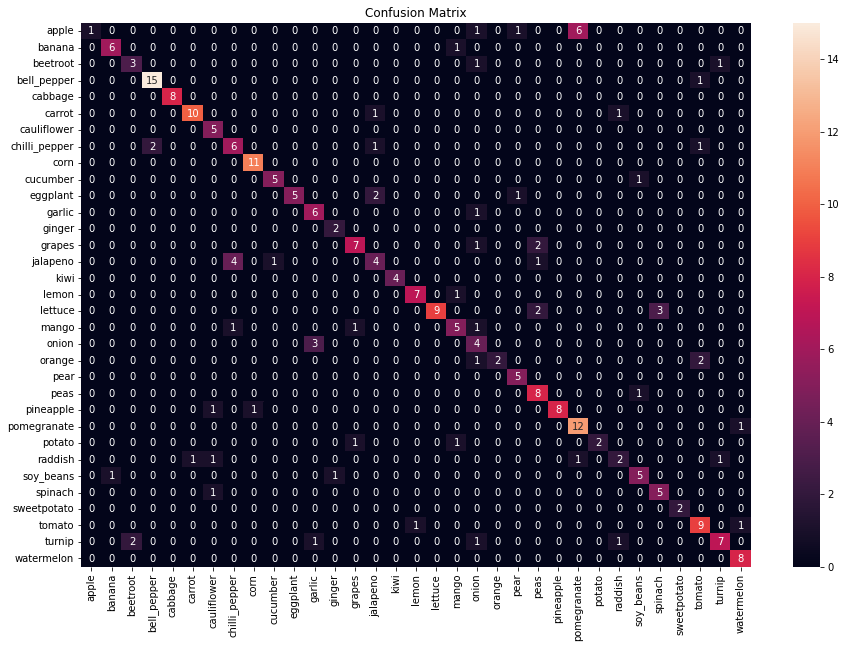

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_2_Aug

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_2_VGG16 = keras.Model(inputs, outputs)
model_2_VGG16.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_VGG16_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 75.6769 - accuracy: 0.5077
Epoch 00001: val_loss improved from inf to 87.31689, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_VGG16_feature_extraction.h5
68/68 [==============================] - 22s 299ms/step - loss: 75.6769 - accuracy: 0.5077 - val_loss: 87.3169 - val_accuracy: 0.6067
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 34.7411 - accuracy: 0.7089
Epoch 00002: val_loss improved from 87.31689 to 71.33077, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_VGG16_feature_extraction.h5
68/68 [==============================] - 21s 307ms/step - loss: 34.7411 - accuracy: 0.7089 - val_loss: 71.3308 - val_accuracy: 0.6527
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 26.3791 - accuracy: 0.7792
Epoch 00003: val_loss improved from 71.33077 to 49.60284, saving model to /content/drive/Shareddrives/CIDL//

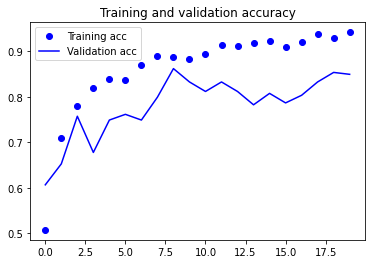

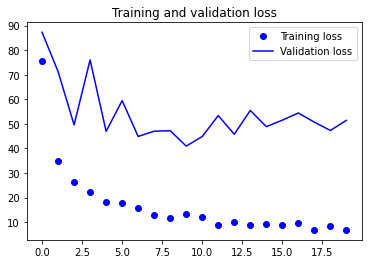

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 231ms/step - loss: 66.8749 - accuracy: 0.7887


0.7886792421340942

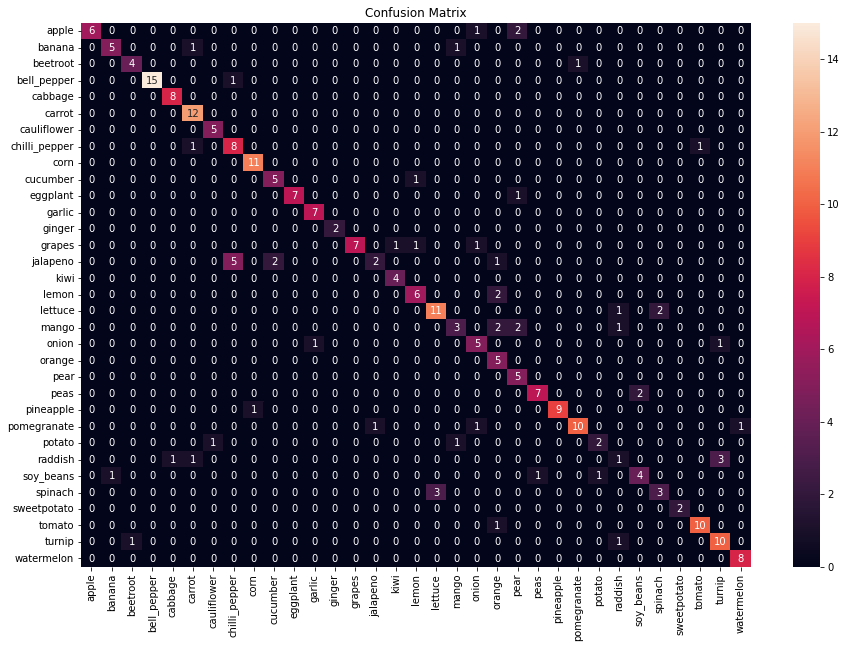

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_VGG16_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 6.6289 - accuracy: 0.9334
Epoch 00001: val_loss improved from inf to 62.75393, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_VGG16_Fine_tuning.h5
68/68 [==============================] - 20s 295ms/step - loss: 6.6289 - accuracy: 0.9334 - val_loss: 62.7539 - val_accuracy: 0.8159
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 6.5667 - accuracy: 0.9390
Epoch 00002: val_loss improved from 62.75393 to 57.66895, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_VGG16_Fine_tuning.h5
68/68 [==============================] - 22s 329ms/step - loss: 6.5667 - accuracy: 0.9390 - val_loss: 57.6689 - val_accuracy: 0.8326
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 5.3081 - accuracy: 0.9450
Epoch 00003: val_loss did not improve from 57.66895
68/68 [==============================] - 19s 285ms/step - loss: 5.3081 - ac

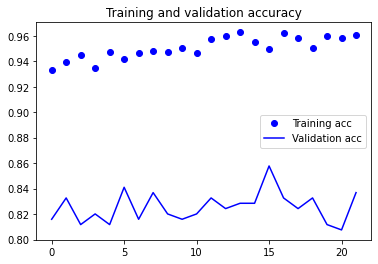

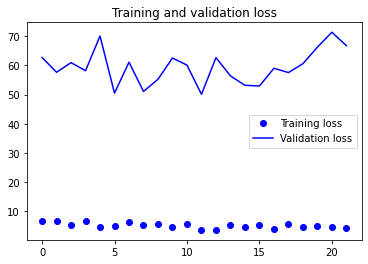

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 234ms/step - loss: 84.7230 - accuracy: 0.8038


0.8037735819816589

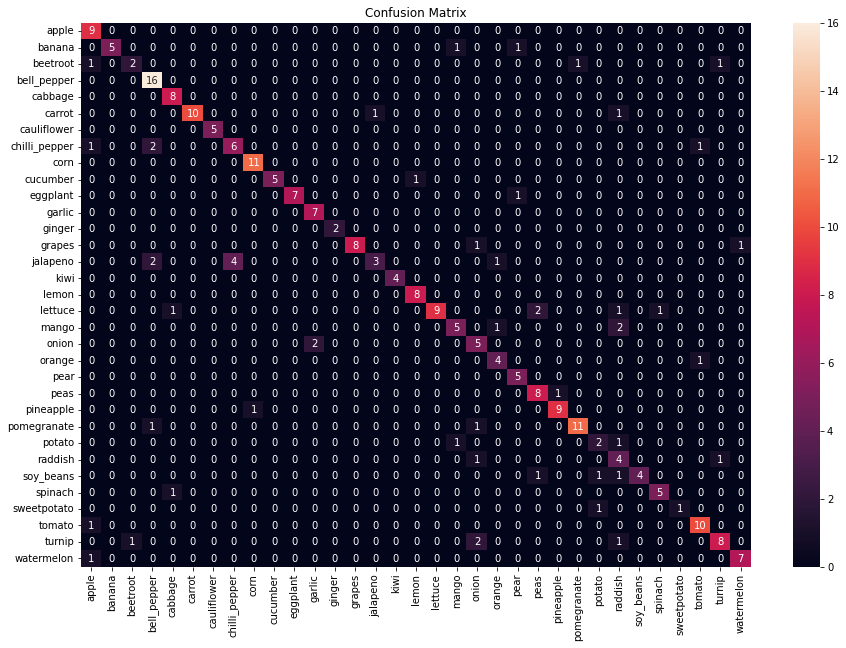

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3a_Drop0.2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3a_VGG16 = keras.Model(inputs, outputs)
model_3a_VGG16.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_VGG16_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 72.3743 - accuracy: 0.4872
Epoch 00001: val_loss improved from inf to 60.98202, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_VGG16_feature_extraction.h5
68/68 [==============================] - 22s 223ms/step - loss: 72.3743 - accuracy: 0.4872 - val_loss: 60.9820 - val_accuracy: 0.6611
Epoch 2/50
67/68 [============================>.] - ETA: 0s - loss: 31.3349 - accuracy: 0.7136
Epoch 00002: val_loss did not improve from 60.98202
68/68 [==============================] - 9s 133ms/step - loss: 31.3732 - accuracy: 0.7131 - val_loss: 70.7847 - val_accuracy: 0.6946
Epoch 3/50
67/68 [============================>.] - ETA: 0s - loss: 25.9613 - accuracy: 0.7687
Epoch 00003: val_loss improved from 60.98202 to 45.22792, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_VGG16_feature_extraction.h5
68/68 [==============================] - 11s 159ms/step

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 3s 364ms/step - loss: 66.9543 - accuracy: 0.8000


0.800000011920929

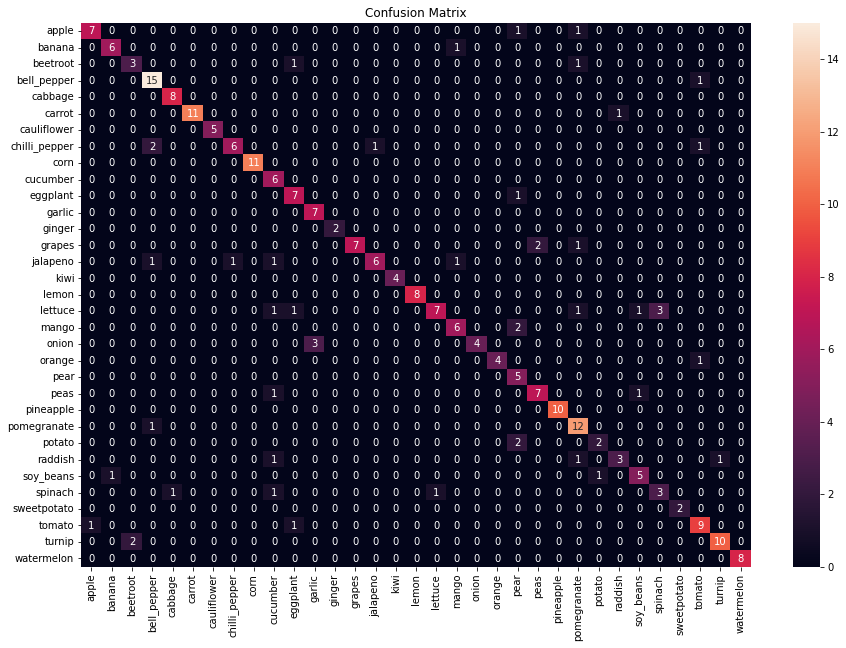

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
67/68 [============================>.] - ETA: 0s - loss: 7.6392 - accuracy: 0.9300
Epoch 00001: val_loss improved from inf to 49.80888, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5
68/68 [==============================] - 10s 145ms/step - loss: 7.6875 - accuracy: 0.9287 - val_loss: 49.8089 - val_accuracy: 0.8452
Epoch 2/50
67/68 [============================>.] - ETA: 0s - loss: 7.1113 - accuracy: 0.9277
Epoch 00002: val_loss improved from 49.80888 to 42.63568, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5
68/68 [==============================] - 10s 143ms/step - loss: 7.1014 - accuracy: 0.9278 - val_loss: 42.6357 - val_accuracy: 0.8619
Epoch 3/50
67/68 [============================>.] - ETA: 0s - loss: 8.7205 - accuracy: 0.9221
Epoch 00003: val_loss did not improve from 42.63568
68/68 [==============================] - 9s 137ms/step - loss: 8.7083 - a

In [ ]:
model_3a_VGG16.save_weights(os.path.join(dir_name,'CategoricalClassifier_Model3a_VGG16_Fine_tuning_weights.h5'))

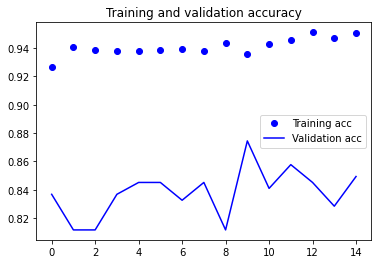

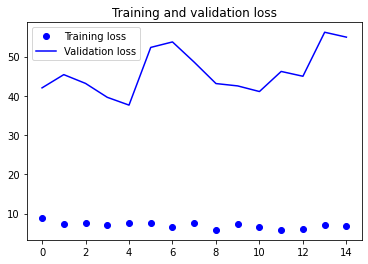

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 1s 112ms/step - loss: 64.1762 - accuracy: 0.8000


0.800000011920929

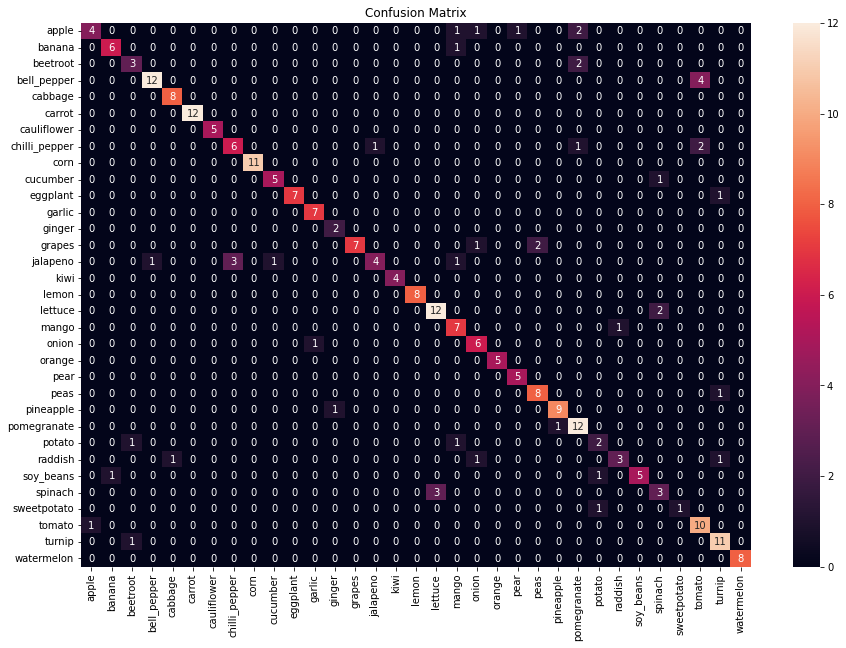

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3b_Drop0.5

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3b_VGG16 = keras.Model(inputs, outputs)
model_3b_VGG16.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_VGG16_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 68.9704 - accuracy: 0.4616
Epoch 00001: val_loss improved from inf to 44.57634, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_VGG16_feature_extraction.h5
68/68 [==============================] - 22s 298ms/step - loss: 68.9704 - accuracy: 0.4616 - val_loss: 44.5763 - val_accuracy: 0.6778
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 39.1462 - accuracy: 0.6502
Epoch 00002: val_loss did not improve from 44.57634
68/68 [==============================] - 19s 285ms/step - loss: 39.1462 - accuracy: 0.6502 - val_loss: 66.0626 - val_accuracy: 0.6946
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 35.6916 - accuracy: 0.7215
Epoch 00003: val_loss did not improve from 44.57634
68/68 [==============================] - 19s 285ms/step - loss: 35.6916 - accuracy: 0.7215 - val_loss: 49.1564 - val_accuracy: 0.7322
Epoch 4/50
68/68 [=======================

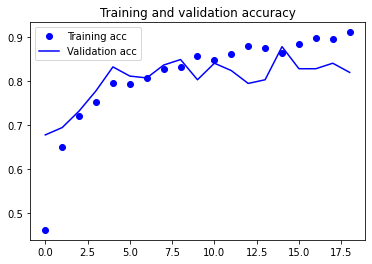

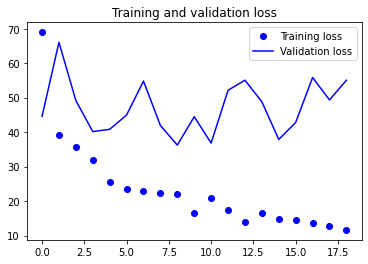

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 231ms/step - loss: 54.6348 - accuracy: 0.7887


0.7886792421340942

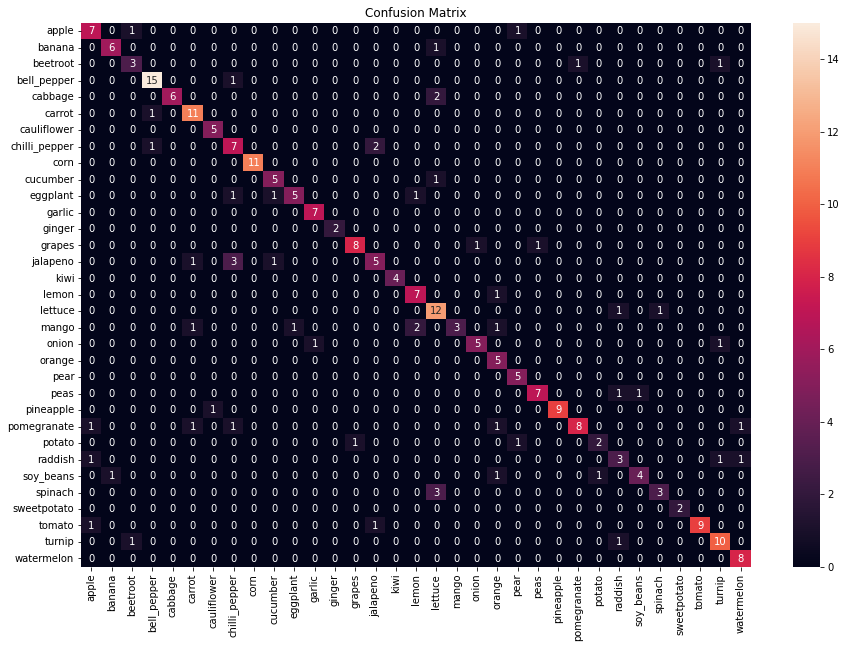

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 12.0611 - accuracy: 0.9031
Epoch 00001: val_loss improved from inf to 46.72792, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5
68/68 [==============================] - 20s 294ms/step - loss: 12.0611 - accuracy: 0.9031 - val_loss: 46.7279 - val_accuracy: 0.8117
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 12.7759 - accuracy: 0.8989
Epoch 00002: val_loss improved from 46.72792 to 43.40884, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5
68/68 [==============================] - 22s 317ms/step - loss: 12.7759 - accuracy: 0.8989 - val_loss: 43.4088 - val_accuracy: 0.8619
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 14.9039 - accuracy: 0.8957
Epoch 00003: val_loss did not improve from 43.40884
68/68 [==============================] - 19s 285ms/step - loss: 14.9

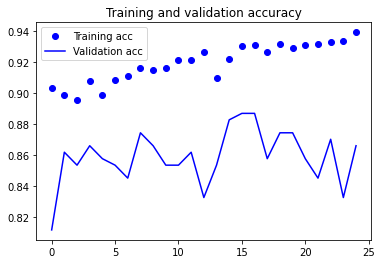

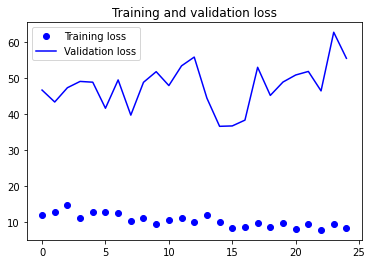

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 230ms/step - loss: 63.7564 - accuracy: 0.8189


0.8188679218292236

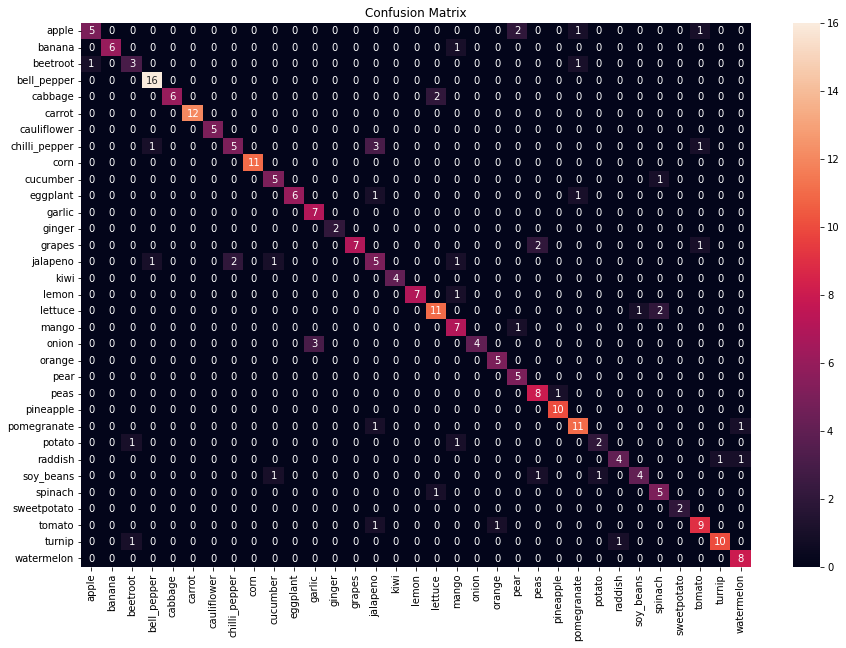

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_4_RelL1L2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=reg)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_4_VGG16 = keras.Model(inputs, outputs)
model_4_VGG16.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_VGG16_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 75.1654 - accuracy: 0.4886
Epoch 00001: val_loss improved from inf to 54.07714, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_VGG16_feature_extraction.h5
68/68 [==============================] - 22s 301ms/step - loss: 75.1654 - accuracy: 0.4886 - val_loss: 54.0771 - val_accuracy: 0.6778
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 33.5091 - accuracy: 0.7010
Epoch 00002: val_loss did not improve from 54.07714
68/68 [==============================] - 20s 288ms/step - loss: 33.5091 - accuracy: 0.7010 - val_loss: 66.6807 - val_accuracy: 0.6736
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 29.3322 - accuracy: 0.7648
Epoch 00003: val_loss did not improve from 54.07714
68/68 [==============================] - 20s 287ms/step - loss: 29.3322 - accuracy: 0.7648 - val_loss: 67.4991 - val_accuracy: 0.7113
Epoch 4/50
68/68 [========================

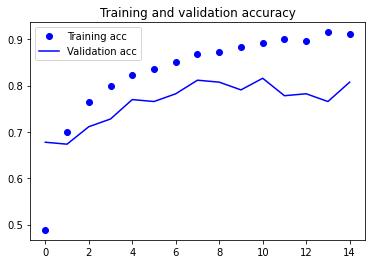

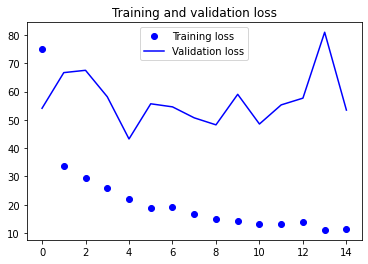

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 231ms/step - loss: 57.5741 - accuracy: 0.8000


0.800000011920929

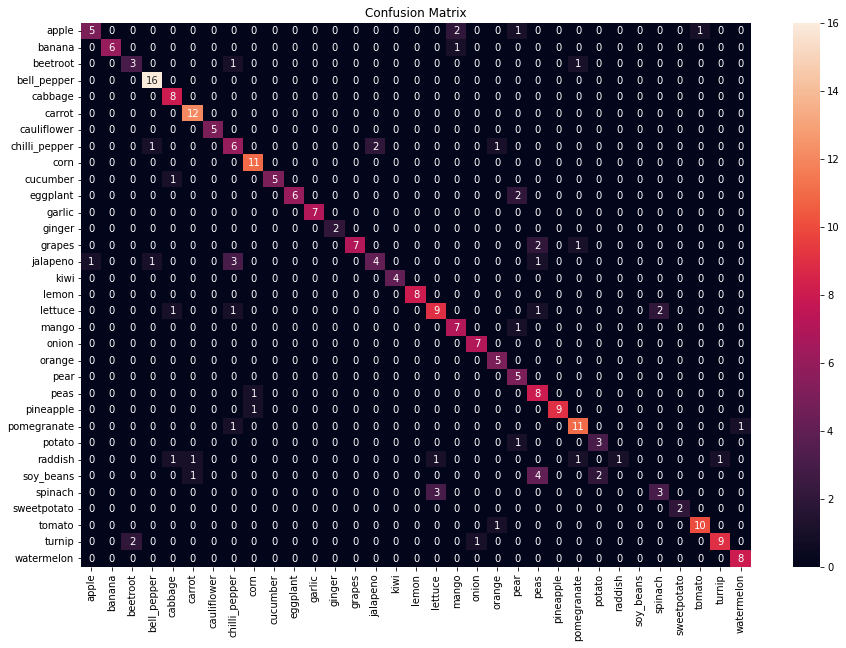

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_VGG16_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_VGG16.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 10.4105 - accuracy: 0.9264
Epoch 00001: val_loss improved from inf to 47.24961, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_VGG16_Fine_tuning.h5
68/68 [==============================] - 20s 296ms/step - loss: 10.4105 - accuracy: 0.9264 - val_loss: 47.2496 - val_accuracy: 0.7950
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 10.1304 - accuracy: 0.9180
Epoch 00002: val_loss did not improve from 47.24961
68/68 [==============================] - 20s 287ms/step - loss: 10.1304 - accuracy: 0.9180 - val_loss: 49.1183 - val_accuracy: 0.8201
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 10.6768 - accuracy: 0.9110
Epoch 00003: val_loss did not improve from 47.24961
68/68 [==============================] - 19s 287ms/step - loss: 10.6768 - accuracy: 0.9110 - val_loss: 66.4059 - val_accuracy: 0.7950
Epoch 4/50
68/68 [==============================]

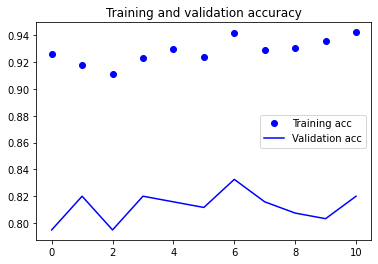

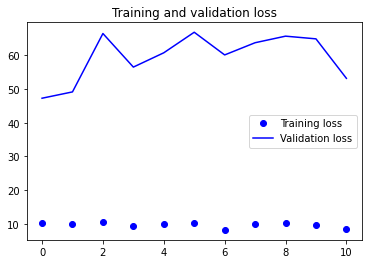

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_VGG16.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 233ms/step - loss: 53.6037 - accuracy: 0.8151


0.8150943517684937

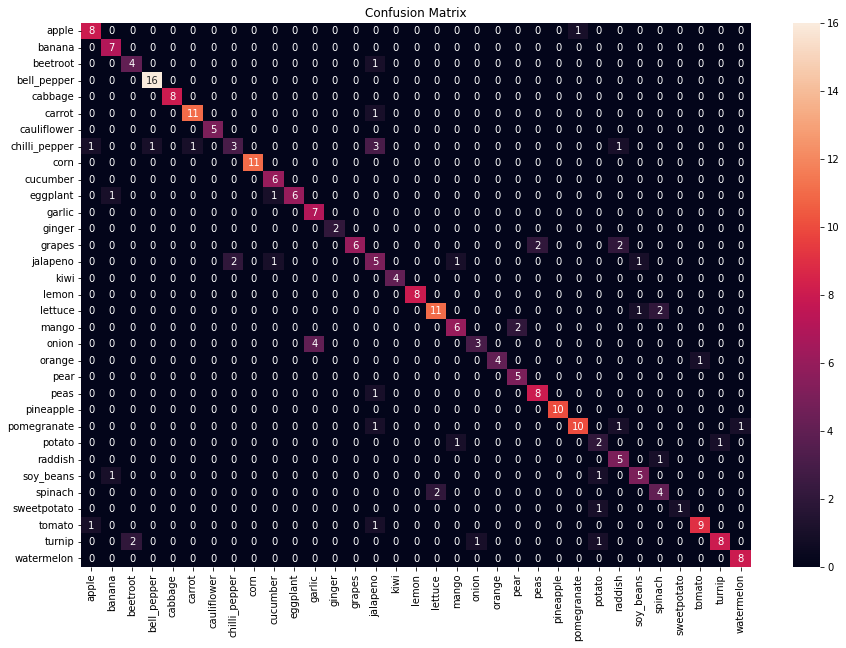

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_VGG16.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

##InceptionV3


In [ ]:
from tensorflow.keras.applications import InceptionV3

conv_base = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

conv_base.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

###Model_1_Base

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_1_Inception = keras.Model(inputs, outputs)
model_1_Inception.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_InceptionV3_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 75.1931 - accuracy: 0.4881
Epoch 00001: val_loss improved from inf to 174.99504, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_InceptionV3_feature_extraction.h5
68/68 [==============================] - 26s 281ms/step - loss: 75.1931 - accuracy: 0.4881 - val_loss: 174.9950 - val_accuracy: 0.1130
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 18.1521 - accuracy: 0.7750
Epoch 00002: val_loss improved from 174.99504 to 18.87081, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_InceptionV3_feature_extraction.h5
68/68 [==============================] - 16s 242ms/step - loss: 18.1521 - accuracy: 0.7750 - val_loss: 18.8708 - val_accuracy: 0.7573
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 10.7075 - accuracy: 0.8444
Epoch 00003: val_loss did not improve from 18.87081
68/68 [==============================] - 

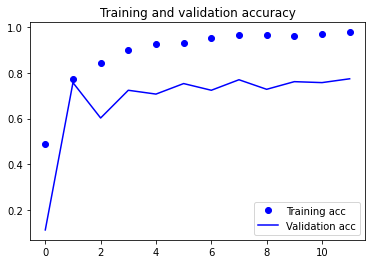

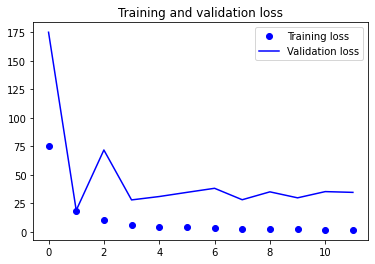

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 3s 293ms/step - loss: 30.0582 - accuracy: 0.7660


0.7660377621650696

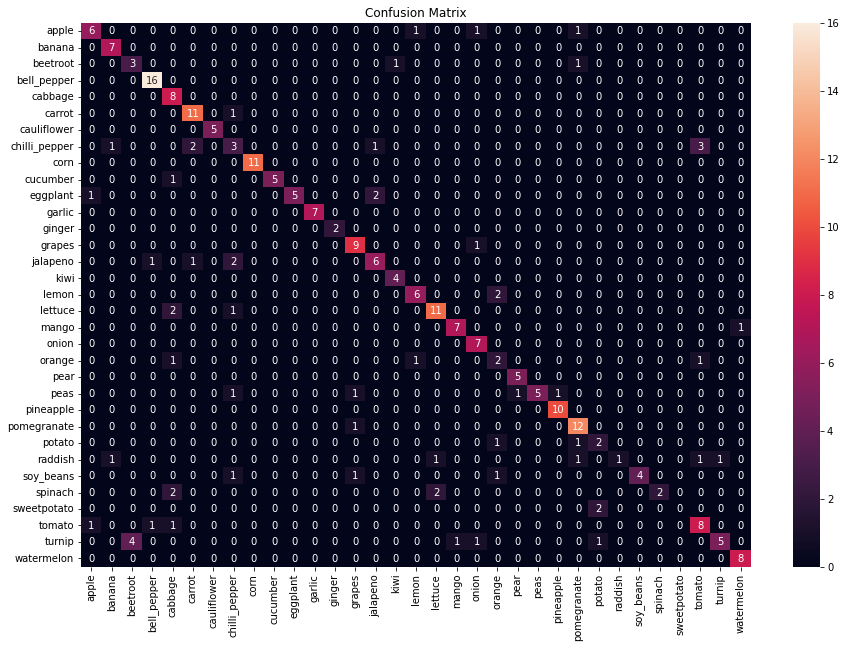

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_InceptionV3_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 2.0973 - accuracy: 0.9721
Epoch 00001: val_loss improved from inf to 31.06672, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 15s 223ms/step - loss: 2.0973 - accuracy: 0.9721 - val_loss: 31.0667 - val_accuracy: 0.7824
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.9360 - accuracy: 0.9879
Epoch 00002: val_loss did not improve from 31.06672
68/68 [==============================] - 13s 198ms/step - loss: 0.9360 - accuracy: 0.9879 - val_loss: 42.6549 - val_accuracy: 0.7238
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 2.0011 - accuracy: 0.9721
Epoch 00003: val_loss improved from 31.06672 to 30.02666, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 16s 239ms/step - loss:

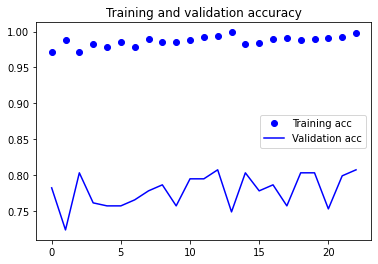

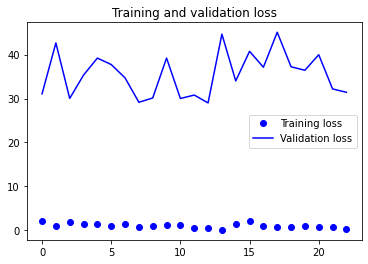

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 164ms/step - loss: 35.1956 - accuracy: 0.7585


0.7584905624389648

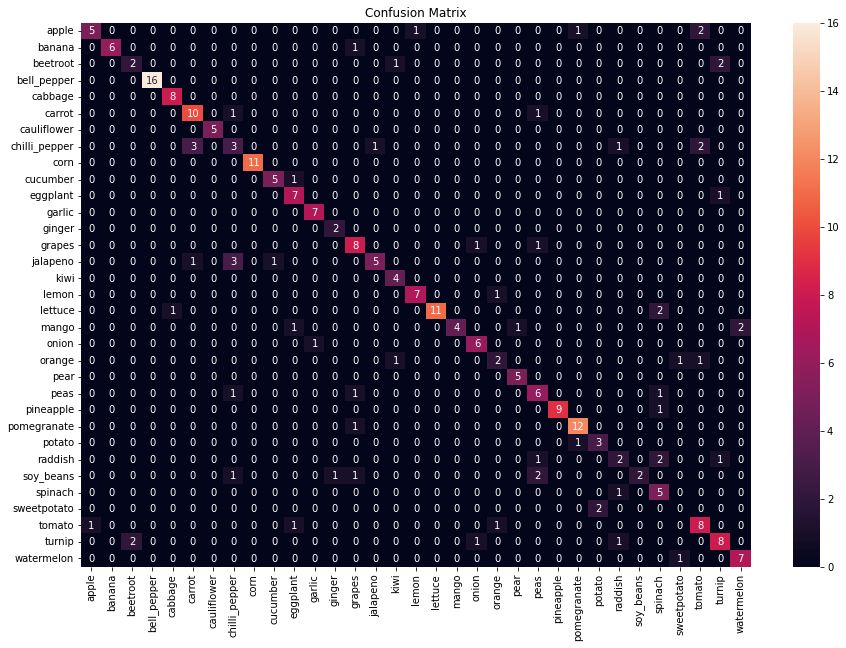

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_2_Aug

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_2_Inception = keras.Model(inputs, outputs)
model_2_Inception.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_InceptionV3_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 95.7275 - accuracy: 0.4048
Epoch 00001: val_loss improved from inf to 109.89140, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_InceptionV3_feature_extraction.h5
68/68 [==============================] - 23s 259ms/step - loss: 95.7275 - accuracy: 0.4048 - val_loss: 109.8914 - val_accuracy: 0.2887
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 32.0136 - accuracy: 0.6251
Epoch 00002: val_loss improved from 109.89140 to 34.91302, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_InceptionV3_feature_extraction.h5
68/68 [==============================] - 17s 251ms/step - loss: 32.0136 - accuracy: 0.6251 - val_loss: 34.9130 - val_accuracy: 0.6151
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 22.3388 - accuracy: 0.7038
Epoch 00003: val_loss improved from 34.91302 to 31.71474, saving model to /content/drive/Shar

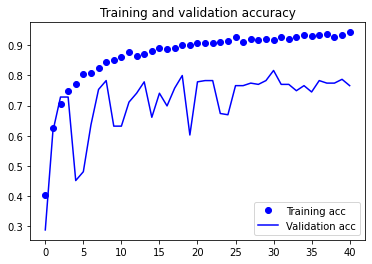

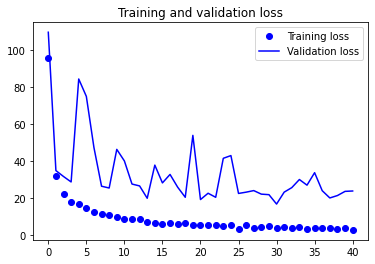

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 165ms/step - loss: 28.7455 - accuracy: 0.7396


0.7396226525306702

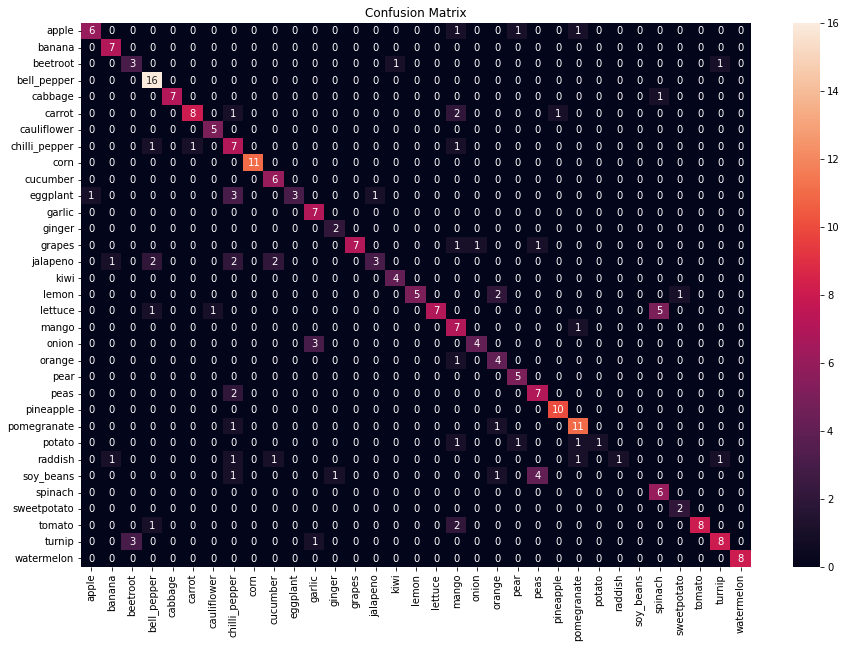

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 3.8309 - accuracy: 0.9339
Epoch 00001: val_loss improved from inf to 18.36892, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 16s 235ms/step - loss: 3.8309 - accuracy: 0.9339 - val_loss: 18.3689 - val_accuracy: 0.8033
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 3.3784 - accuracy: 0.9339
Epoch 00002: val_loss improved from 18.36892 to 17.31673, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 17s 246ms/step - loss: 3.3784 - accuracy: 0.9339 - val_loss: 17.3167 - val_accuracy: 0.8033
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 2.9659 - accuracy: 0.9497
Epoch 00003: val_loss did not improve from 17.31673
68/68 [==============================] - 14s 208ms/step - loss:

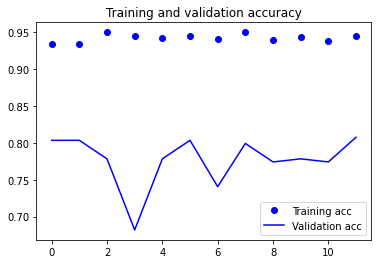

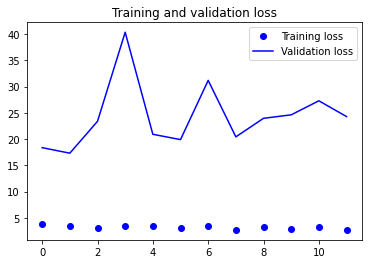

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 162ms/step - loss: 23.3955 - accuracy: 0.7849


0.7849056720733643

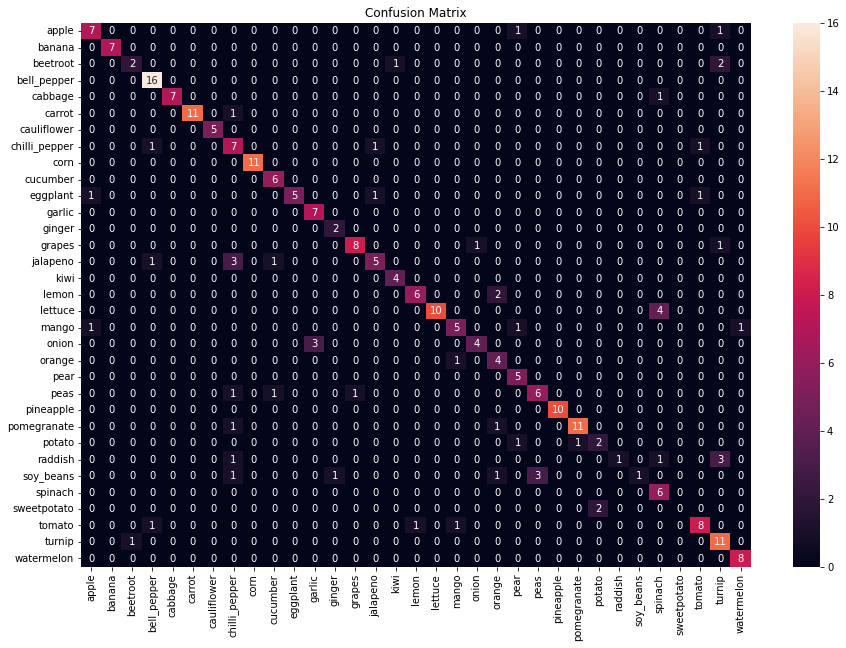

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3a_Drop0.2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3a_Inception = keras.Model(inputs, outputs)
model_3a_Inception.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_InceptionV3_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 75.8733 - accuracy: 0.4173
Epoch 00001: val_loss improved from inf to 50.10870, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_InceptionV3_feature_extraction.h5
68/68 [==============================] - 23s 259ms/step - loss: 75.8733 - accuracy: 0.4173 - val_loss: 50.1087 - val_accuracy: 0.4351
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 30.0987 - accuracy: 0.6218
Epoch 00002: val_loss did not improve from 50.10870
68/68 [==============================] - 14s 208ms/step - loss: 30.0987 - accuracy: 0.6218 - val_loss: 69.5266 - val_accuracy: 0.4477
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 24.5214 - accuracy: 0.6800
Epoch 00003: val_loss did not improve from 50.10870
68/68 [==============================] - 14s 206ms/step - loss: 24.5214 - accuracy: 0.6800 - val_loss: 68.4136 - val_accuracy: 0.4812
Epoch 4/50
68/68 [=================

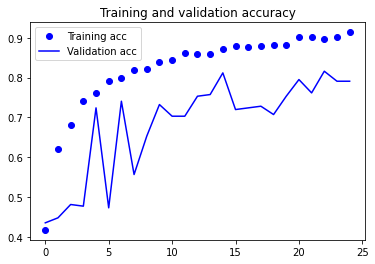

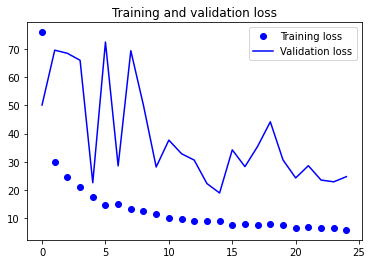

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 166ms/step - loss: 22.4088 - accuracy: 0.7811


0.7811321020126343

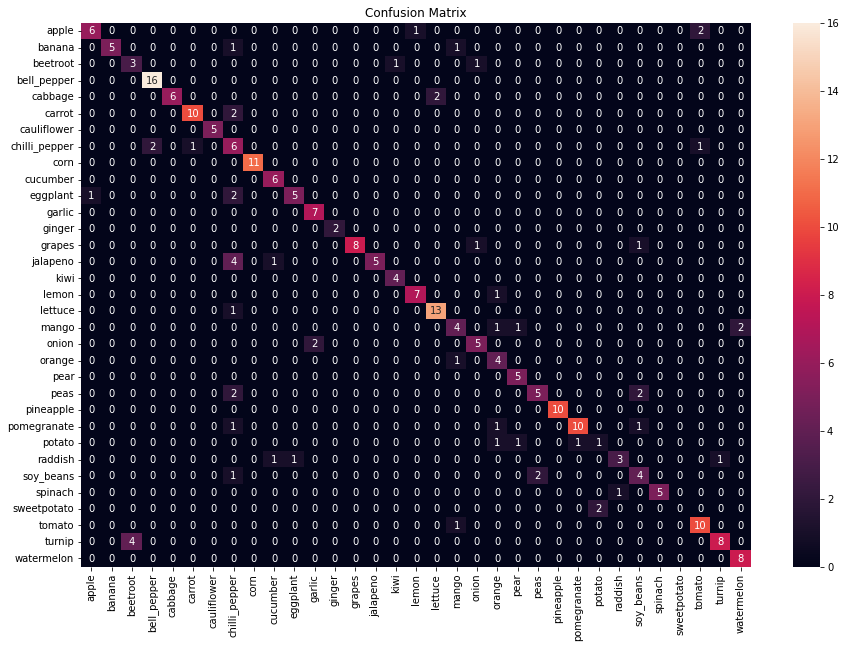

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_InceptionV3_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 6.4911 - accuracy: 0.9078
Epoch 00001: val_loss improved from inf to 29.39197, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 16s 229ms/step - loss: 6.4911 - accuracy: 0.9078 - val_loss: 29.3920 - val_accuracy: 0.7657
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 5.6122 - accuracy: 0.9110
Epoch 00002: val_loss improved from 29.39197 to 22.56297, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 17s 248ms/step - loss: 5.6122 - accuracy: 0.9110 - val_loss: 22.5630 - val_accuracy: 0.7824
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 5.7657 - accuracy: 0.9176
Epoch 00003: val_loss did not improve from 22.56297
68/68 [==============================] - 14s 207ms/step - los

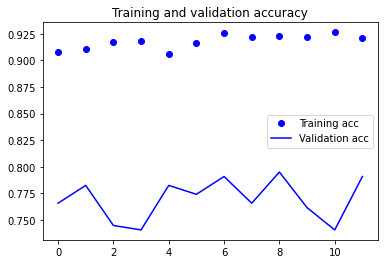

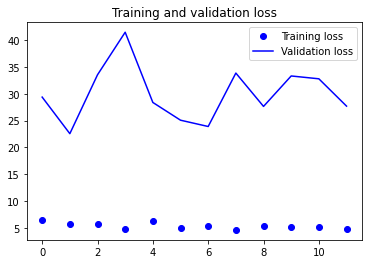

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 164ms/step - loss: 24.4868 - accuracy: 0.7811


0.7811321020126343

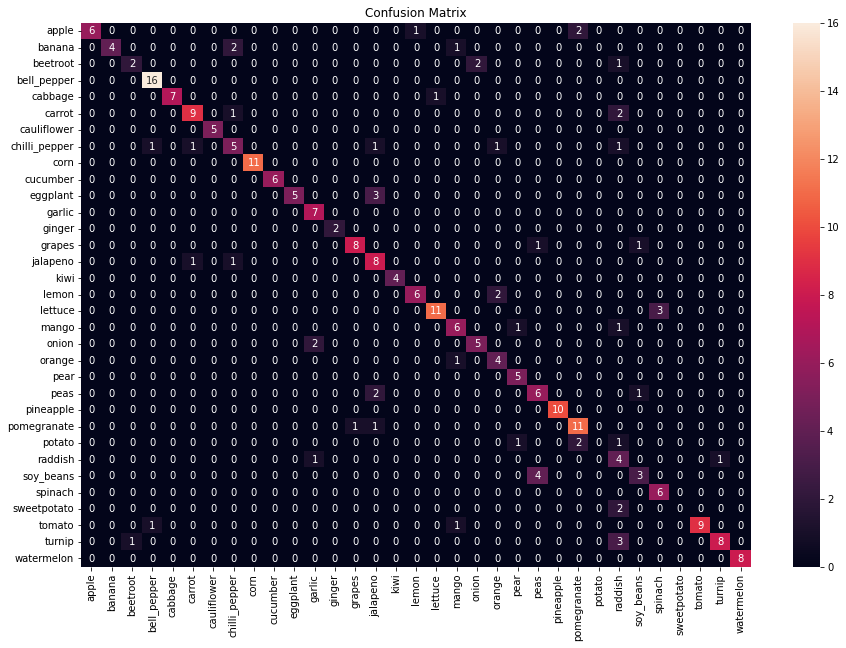

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3b_Drop0.5

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3b_Inception = keras.Model(inputs, outputs)
model_3b_Inception.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_InceptionV3_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 63.5552 - accuracy: 0.4075
Epoch 00001: val_loss improved from inf to 90.81676, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_InceptionV3_feature_extraction.h5
68/68 [==============================] - 23s 251ms/step - loss: 63.5552 - accuracy: 0.4075 - val_loss: 90.8168 - val_accuracy: 0.3222
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 31.8767 - accuracy: 0.5789
Epoch 00002: val_loss improved from 90.81676 to 48.57370, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_InceptionV3_feature_extraction.h5
68/68 [==============================] - 17s 247ms/step - loss: 31.8767 - accuracy: 0.5789 - val_loss: 48.5737 - val_accuracy: 0.5021
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 27.8845 - accuracy: 0.6497
Epoch 00003: val_loss did not improve from 48.57370
68/68 [==============================] - 1

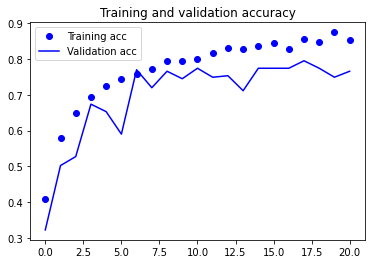

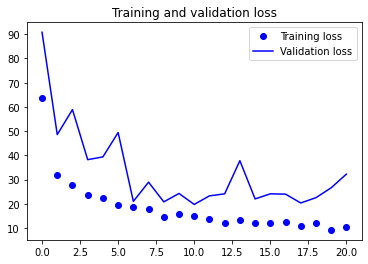

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 165ms/step - loss: 30.2148 - accuracy: 0.7660


0.7660377621650696

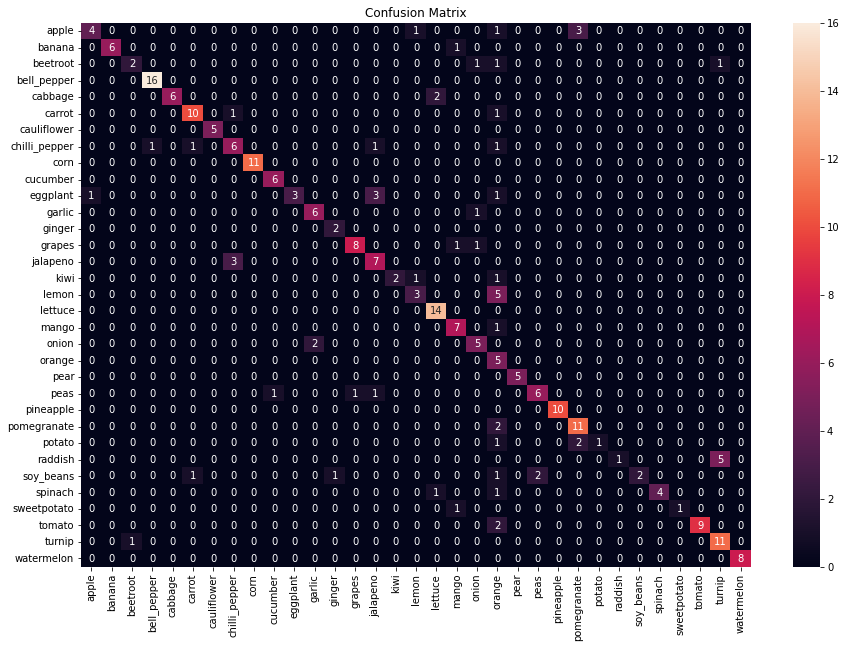

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_InceptionV3_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 11.0836 - accuracy: 0.8626
Epoch 00001: val_loss improved from inf to 28.86001, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 16s 229ms/step - loss: 11.0836 - accuracy: 0.8626 - val_loss: 28.8600 - val_accuracy: 0.7699
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 8.8498 - accuracy: 0.8752
Epoch 00002: val_loss improved from 28.86001 to 23.72566, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 17s 247ms/step - loss: 8.8498 - accuracy: 0.8752 - val_loss: 23.7257 - val_accuracy: 0.7992
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 9.5387 - accuracy: 0.8710
Epoch 00003: val_loss did not improve from 23.72566
68/68 [==============================] - 14s 208ms/step - l

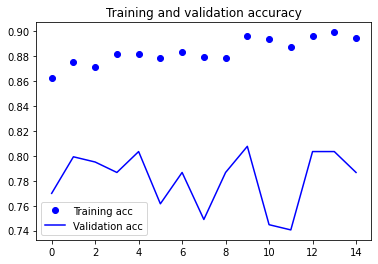

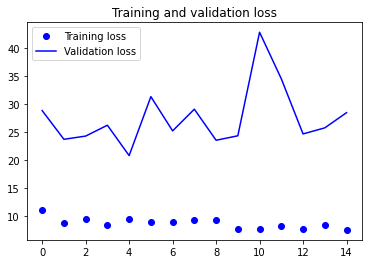

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 167ms/step - loss: 30.5821 - accuracy: 0.7811


0.7811321020126343

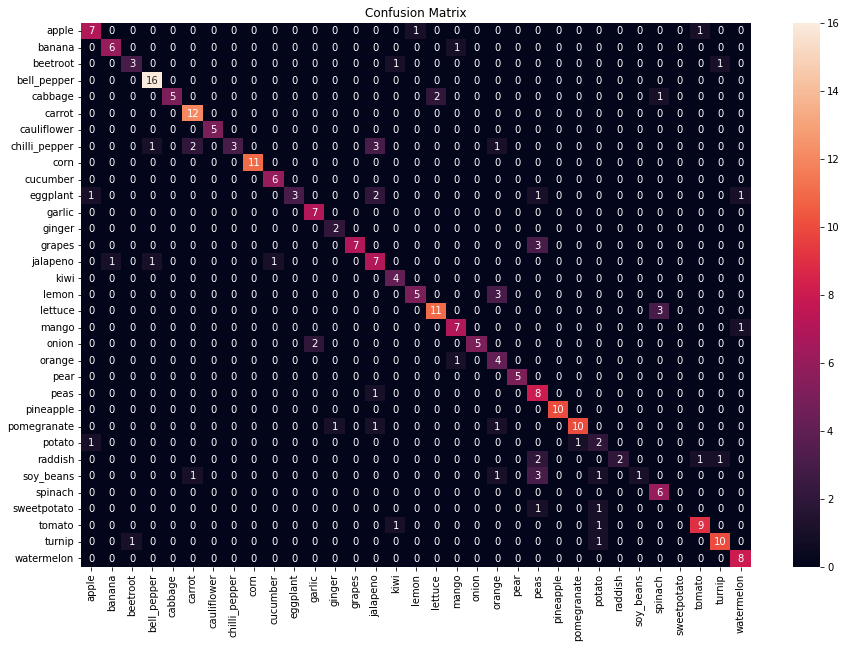

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_4_RelL1L2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=reg)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_4_Inception = keras.Model(inputs, outputs)
model_4_Inception.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_InceptionV3_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 80.4710 - accuracy: 0.4061
Epoch 00001: val_loss improved from inf to 74.94853, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_InceptionV3_feature_extraction.h5
68/68 [==============================] - 24s 261ms/step - loss: 80.4710 - accuracy: 0.4061 - val_loss: 74.9485 - val_accuracy: 0.4226
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 29.8423 - accuracy: 0.6209
Epoch 00002: val_loss did not improve from 74.94853
68/68 [==============================] - 15s 216ms/step - loss: 29.8423 - accuracy: 0.6209 - val_loss: 85.5372 - val_accuracy: 0.4351
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 25.6356 - accuracy: 0.7019
Epoch 00003: val_loss did not improve from 74.94853
68/68 [==============================] - 15s 215ms/step - loss: 25.6356 - accuracy: 0.7019 - val_loss: 114.7944 - val_accuracy: 0.3556
Epoch 4/50
68/68 [=================

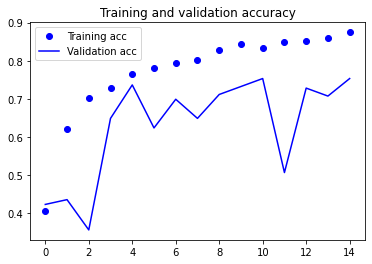

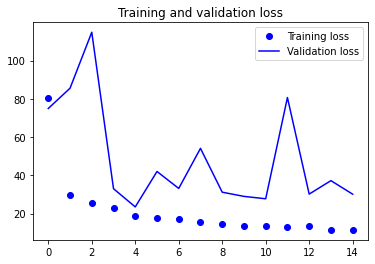

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 165ms/step - loss: 25.7500 - accuracy: 0.7660


0.7660377621650696

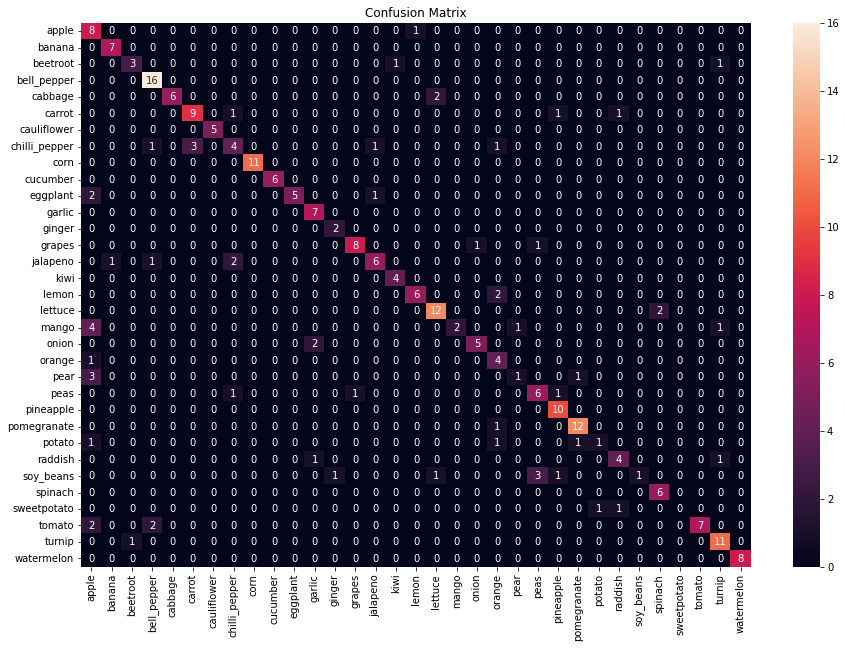

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_InceptionV3_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_Inception.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 10.7355 - accuracy: 0.8784
Epoch 00001: val_loss improved from inf to 55.79090, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 16s 240ms/step - loss: 10.7355 - accuracy: 0.8784 - val_loss: 55.7909 - val_accuracy: 0.6402
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 11.3571 - accuracy: 0.8710
Epoch 00002: val_loss improved from 55.79090 to 32.21297, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_InceptionV3_Fine_tuning.h5
68/68 [==============================] - 17s 257ms/step - loss: 11.3571 - accuracy: 0.8710 - val_loss: 32.2130 - val_accuracy: 0.7615
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 11.1789 - accuracy: 0.8756
Epoch 00003: val_loss improved from 32.21297 to 30.71881, saving model to /content/drive/Shareddrives/CIDL//mo

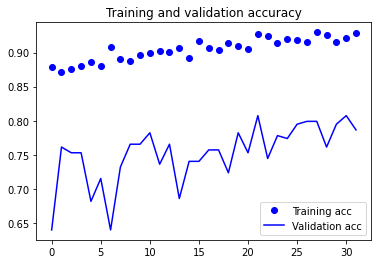

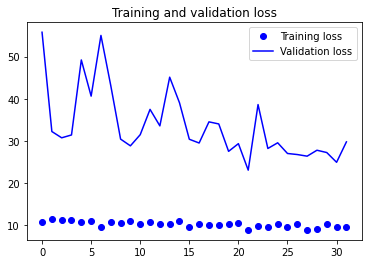

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_Inception.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 167ms/step - loss: 28.6989 - accuracy: 0.7849


0.7849056720733643

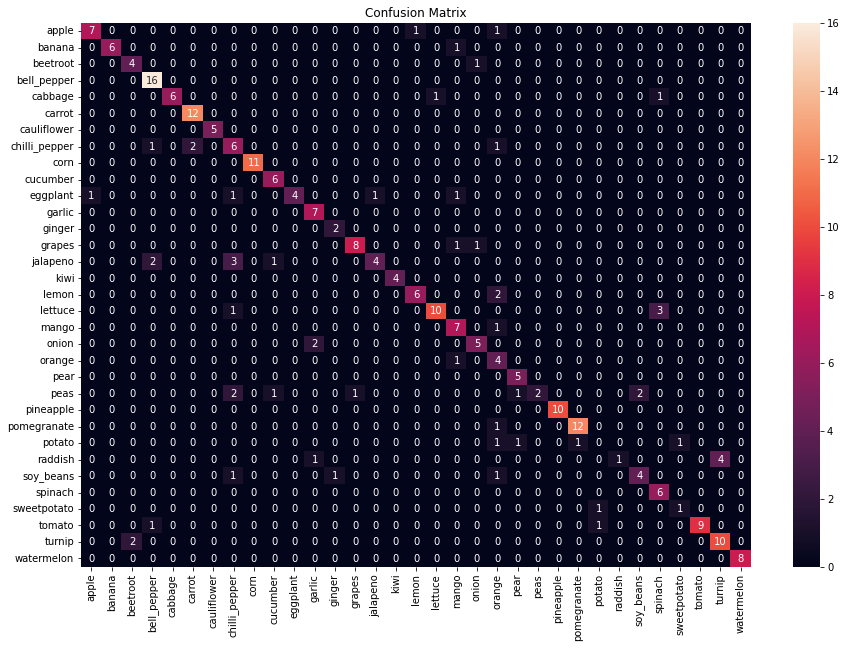

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_Inception.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

##ResNet50


In [ ]:
from tensorflow.keras.applications import ResNet50

conv_base = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

conv_base.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

###Model_1_Base

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_1_ResNet = keras.Model(inputs, outputs)
model_1_ResNet.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_ResNet50_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 55.4597 - accuracy: 0.6167
Epoch 00001: val_loss improved from inf to 44.30769, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_ResNet50_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 27s 316ms/step - loss: 55.4597 - accuracy: 0.6167 - val_loss: 44.3077 - val_accuracy: 0.6820
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 8.0264 - accuracy: 0.9129
Epoch 00002: val_loss did not improve from 44.30769
68/68 [==============================] - 17s 252ms/step - loss: 8.0264 - accuracy: 0.9129 - val_loss: 54.5836 - val_accuracy: 0.6778
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 5.1903 - accuracy: 0.9460
Epoch 00003: val_loss improved from 44.30769 to 36.61520, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_ResNet50_feature_extraction.h5
68/68 [==============================] - 21s 315ms/step - loss: 5.1903 - accuracy: 0.9460 - val_loss: 36.6152 - val_accuracy: 0.7364
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 4.6505 - accuracy: 0.9544
Epoch 00004: val_loss improved from 36.61520 to 34.16397, saving model to /content/drive/Sh

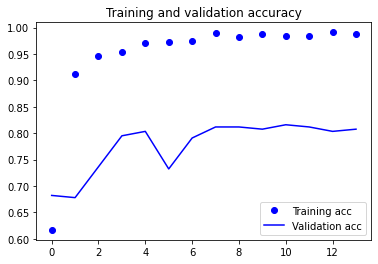

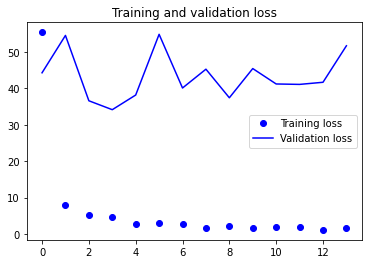

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 3s 292ms/step - loss: 60.8010 - accuracy: 0.7396


0.7396226525306702

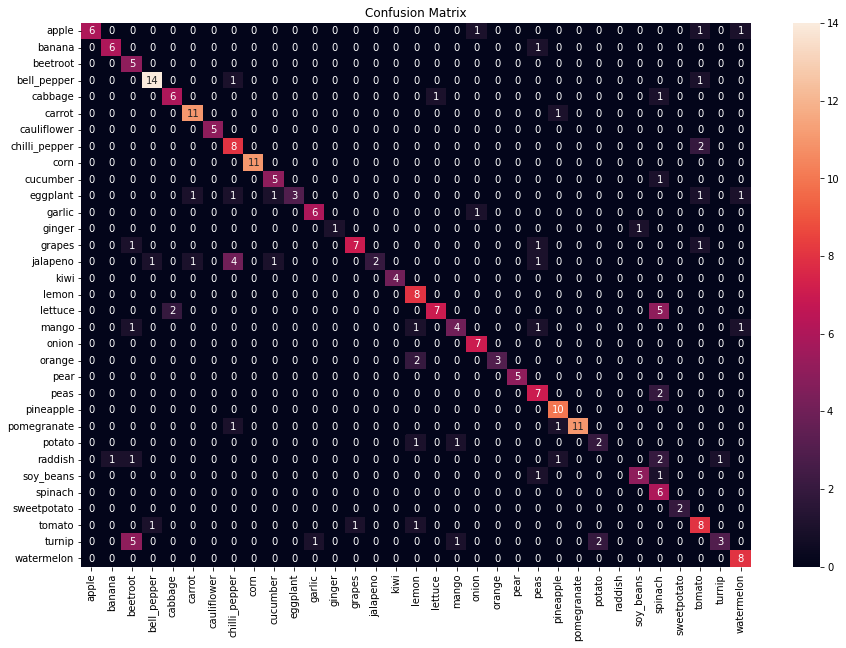

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model1_ResNet50_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_1_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 1.1447 - accuracy: 0.9912
Epoch 00001: val_loss improved from inf to 45.08216, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model1_ResNet50_Fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 19s 283ms/step - loss: 1.1447 - accuracy: 0.9912 - val_loss: 45.0822 - val_accuracy: 0.8201
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.9916
Epoch 00002: val_loss did not improve from 45.08216
68/68 [==============================] - 17s 252ms/step - loss: 0.9571 - accuracy: 0.9916 - val_loss: 48.6866 - val_accuracy: 0.7950
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 1.3671 - accuracy: 0.9893
Epoch 00003: val_loss did not improve from 45.08216
68/68 [==============================] - 17s 251ms/step - loss: 1.3671 - accuracy: 0.9893 - val_loss: 53.6386 - val_accuracy: 0.7950
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 1.0611 - accuracy: 0.9935
Epoch 00004: val_loss did not improve from 45.08216
68/68 [==============================] - 17s 251ms/step - loss: 1.0611 - accuracy: 0.9935 - val_loss: 49.2613 - val_accuracy: 0.7992
Epoch 5/50
68/68 [============

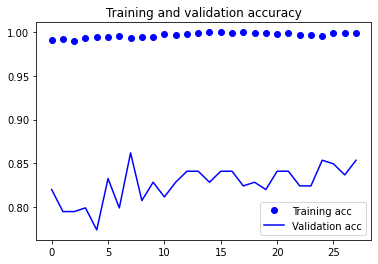

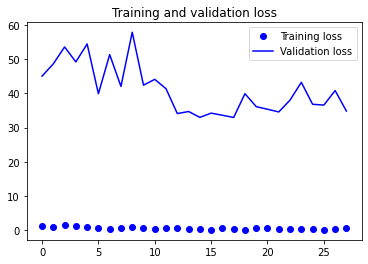

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_1_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 203ms/step - loss: 35.6251 - accuracy: 0.8340


0.8339622616767883

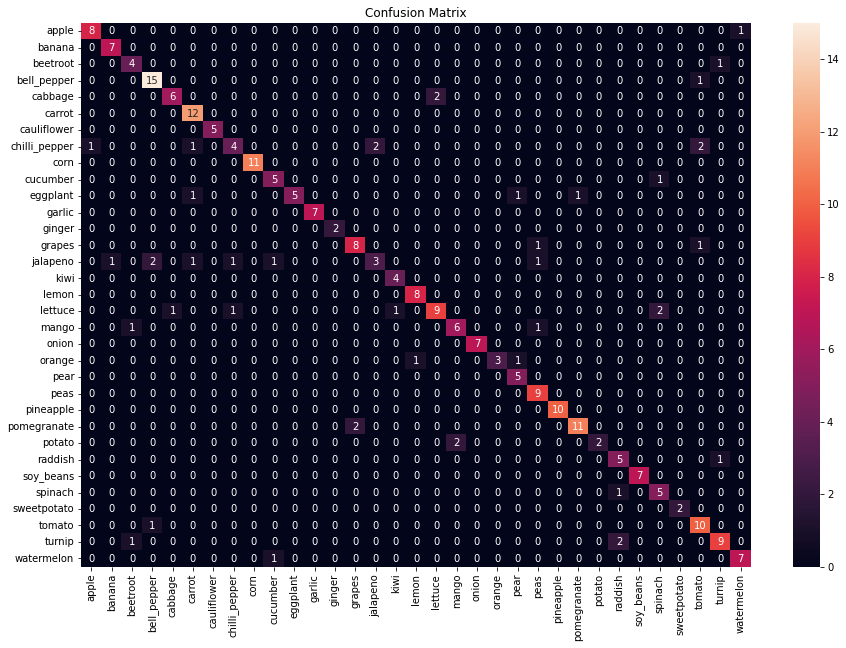

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_1_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_2_Aug

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_2_ResNet = keras.Model(inputs, outputs)
model_2_ResNet.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_ResNet50_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 55.5876 - accuracy: 0.5585
Epoch 00001: val_loss improved from inf to 25.80151, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_ResNet50_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 27s 332ms/step - loss: 55.5876 - accuracy: 0.5585 - val_loss: 25.8015 - val_accuracy: 0.7322
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 20.4795 - accuracy: 0.7774
Epoch 00002: val_loss did not improve from 25.80151
68/68 [==============================] - 19s 281ms/step - loss: 20.4795 - accuracy: 0.7774 - val_loss: 56.9001 - val_accuracy: 0.6485
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 14.7517 - accuracy: 0.8291
Epoch 00003: val_loss did not improve from 25.80151
68/68 [==============================] - 19s 277ms/step - loss: 14.7517 - accuracy: 0.8291 - val_loss: 44.7694 - val_accuracy: 0.7071
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 12.9860 - accuracy: 0.8533
Epoch 00004: val_loss improved from 25.80151 to 19.48283, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_ResNet50_feature_extraction.h5
68/68 [===========================

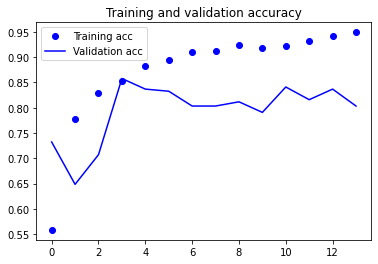

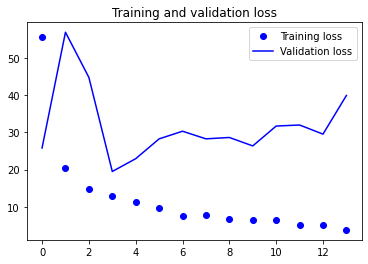

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 199ms/step - loss: 40.7275 - accuracy: 0.7962


0.796226441860199

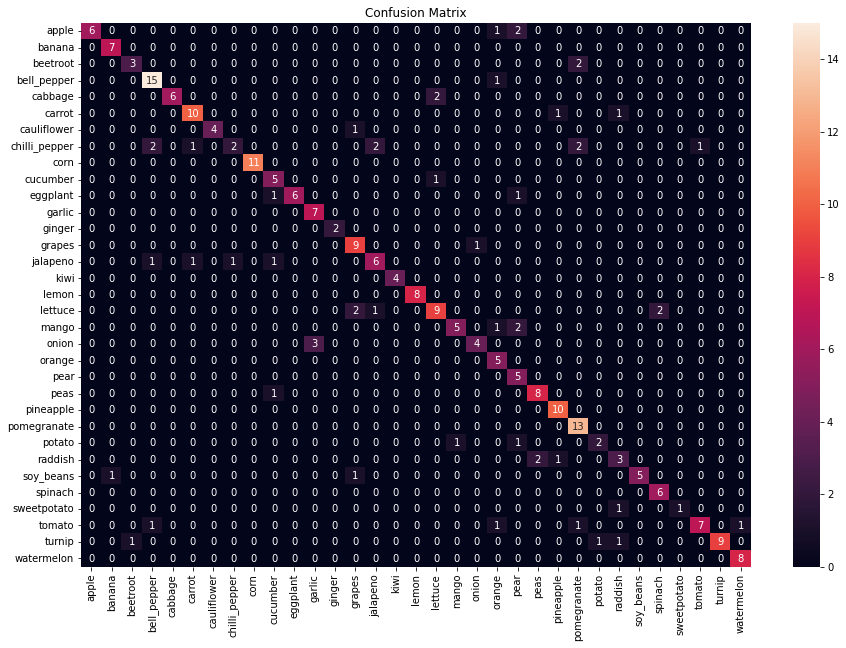

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model2_ResNet50_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_2_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 4.2912 - accuracy: 0.9492
Epoch 00001: val_loss improved from inf to 30.07267, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_ResNet50_Fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 21s 311ms/step - loss: 4.2912 - accuracy: 0.9492 - val_loss: 30.0727 - val_accuracy: 0.8075
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 4.5222 - accuracy: 0.9483
Epoch 00002: val_loss did not improve from 30.07267
68/68 [==============================] - 19s 280ms/step - loss: 4.5222 - accuracy: 0.9483 - val_loss: 34.9662 - val_accuracy: 0.8452
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 2.7584 - accuracy: 0.9609
Epoch 00003: val_loss improved from 30.07267 to 30.02121, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model2_ResNet50_Fine_tuning.h5
68/68 [==============================] - 23s 337ms/step - loss: 2.7584 - accuracy: 0.9609 - val_loss: 30.0212 - val_accuracy: 0.8410
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 3.4102 - accuracy: 0.9595
Epoch 00004: val_loss improved from 30.02121 to 28.42081, saving model to /content/drive/Shareddriv

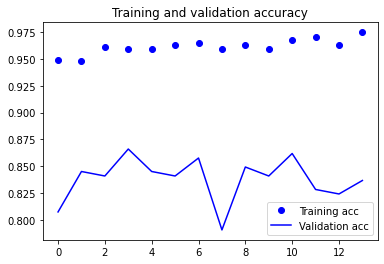

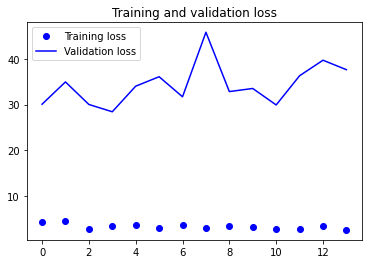

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_2_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 201ms/step - loss: 48.3084 - accuracy: 0.7962


0.796226441860199

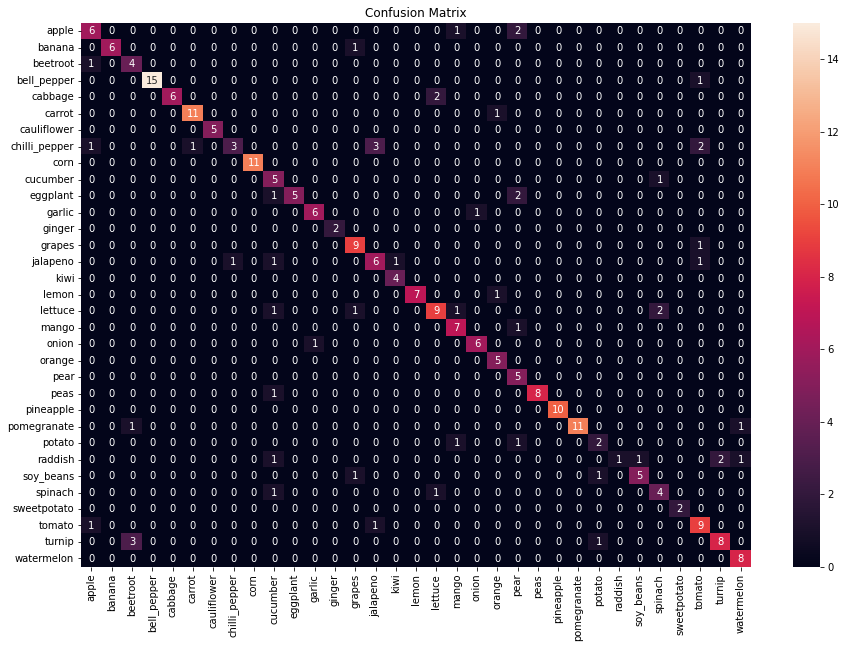

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_2_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3a_Drop0.2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3a_ResNet = keras.Model(inputs, outputs)
model_3a_ResNet.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_ResNet50_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 52.8349 - accuracy: 0.5300
Epoch 00001: val_loss improved from inf to 61.37682, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_ResNet50_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 32s 281ms/step - loss: 52.8349 - accuracy: 0.5300 - val_loss: 61.3768 - val_accuracy: 0.5607
Epoch 2/50
67/68 [============================>.] - ETA: 0s - loss: 22.0208 - accuracy: 0.7570
Epoch 00002: val_loss improved from 61.37682 to 33.03918, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_ResNet50_feature_extraction.h5
68/68 [==============================] - 10s 147ms/step - loss: 22.0381 - accuracy: 0.7569 - val_loss: 33.0392 - val_accuracy: 0.7531
Epoch 3/50
67/68 [============================>.] - ETA: 0s - loss: 16.5996 - accuracy: 0.8153
Epoch 00003: val_loss did not improve from 33.03918
68/68 [==============================] - 9s 126ms/step - loss: 16.5880 - accuracy: 0.8151 - val_loss: 38.5374 - val_accuracy: 0.7531
Epoch 4/50
67/68 [============================>.] - ETA: 0s - loss: 13.4635 - accuracy: 0.8521
Epoch 00004: val_loss improved from 33.03918 to 32.63237, saving model to /content/dri

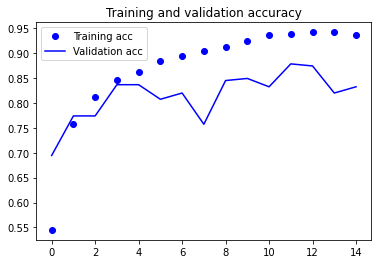

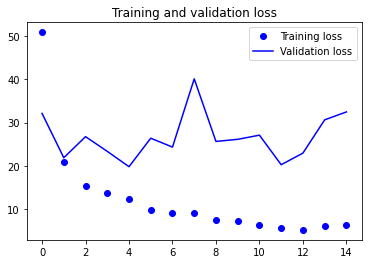

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 1s 139ms/step - loss: 38.4432 - accuracy: 0.8189


0.8188679218292236

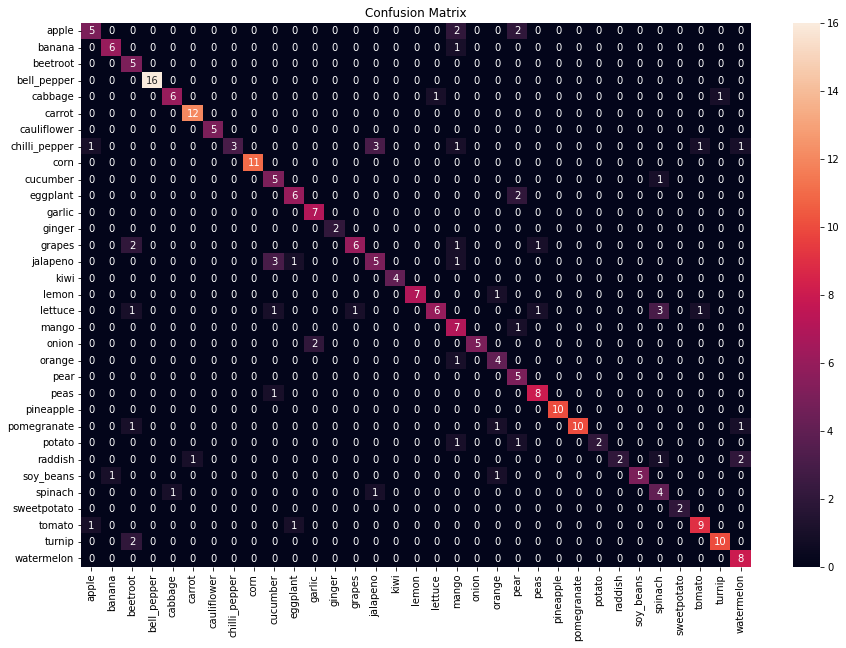

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3a_ResNet50_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3a_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
67/68 [============================>.] - ETA: 0s - loss: 5.1934 - accuracy: 0.9473
Epoch 00001: val_loss improved from inf to 30.03067, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3a_ResNet50_Fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 16s 244ms/step - loss: 5.1861 - accuracy: 0.9474 - val_loss: 30.0307 - val_accuracy: 0.8368
Epoch 2/50
67/68 [============================>.] - ETA: 0s - loss: 6.4785 - accuracy: 0.9408
Epoch 00002: val_loss did not improve from 30.03067
68/68 [==============================] - 9s 126ms/step - loss: 6.4694 - accuracy: 0.9408 - val_loss: 31.7094 - val_accuracy: 0.8368
Epoch 3/50
67/68 [============================>.] - ETA: 0s - loss: 5.3351 - accuracy: 0.9520
Epoch 00003: val_loss did not improve from 30.03067
68/68 [==============================] - 9s 128ms/step - loss: 5.3276 - accuracy: 0.9520 - val_loss: 45.5646 - val_accuracy: 0.8243
Epoch 4/50
67/68 [============================>.] - ETA: 0s - loss: 4.9324 - accuracy: 0.9501
Epoch 00004: val_loss did not improve from 30.03067
68/68 [==============================] - 9s 126ms/step - loss: 4.9255 - accuracy: 0.9502 - val_loss: 35.8818 - val_accuracy: 0.8117
Epoch 5/50
67/68 [===============

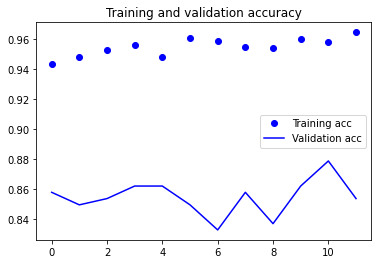

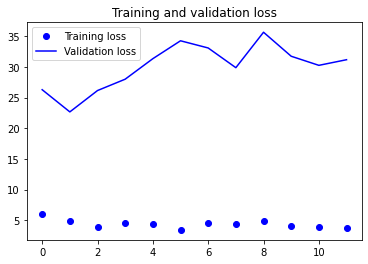

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3a_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 1s 89ms/step - loss: 38.0970 - accuracy: 0.8302


0.8301886916160583

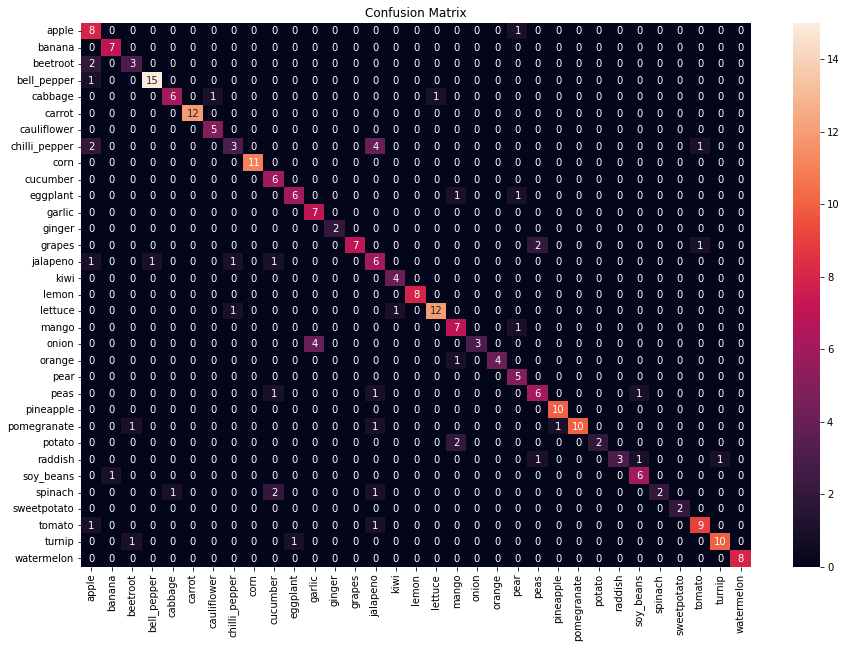

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3a_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_3b_Drop0.5

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_3b_ResNet = keras.Model(inputs, outputs)
model_3b_ResNet.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_ResNet50_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 53.6690 - accuracy: 0.5095
Epoch 00001: val_loss improved from inf to 22.28965, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_ResNet50_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 27s 324ms/step - loss: 53.6690 - accuracy: 0.5095 - val_loss: 22.2896 - val_accuracy: 0.7490
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 25.6910 - accuracy: 0.7126
Epoch 00002: val_loss did not improve from 22.28965
68/68 [==============================] - 20s 292ms/step - loss: 25.6910 - accuracy: 0.7126 - val_loss: 25.4235 - val_accuracy: 0.7741
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 19.7863 - accuracy: 0.7834
Epoch 00003: val_loss improved from 22.28965 to 21.36555, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_ResNet50_feature_extraction.h5
68/68 [==============================] - 22s 330ms/step - loss: 19.7863 - accuracy: 0.7834 - val_loss: 21.3656 - val_accuracy: 0.7908
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 16.1383 - accuracy: 0.8174
Epoch 00004: val_loss did not improve from 21.36555
68/68 [==========================

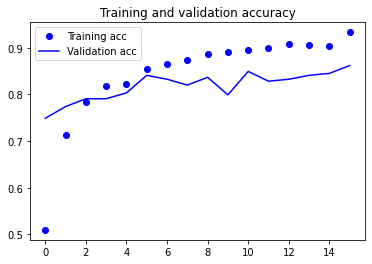

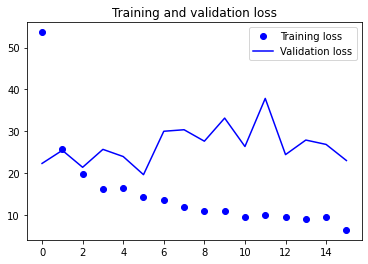

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 199ms/step - loss: 41.5839 - accuracy: 0.7849


0.7849056720733643

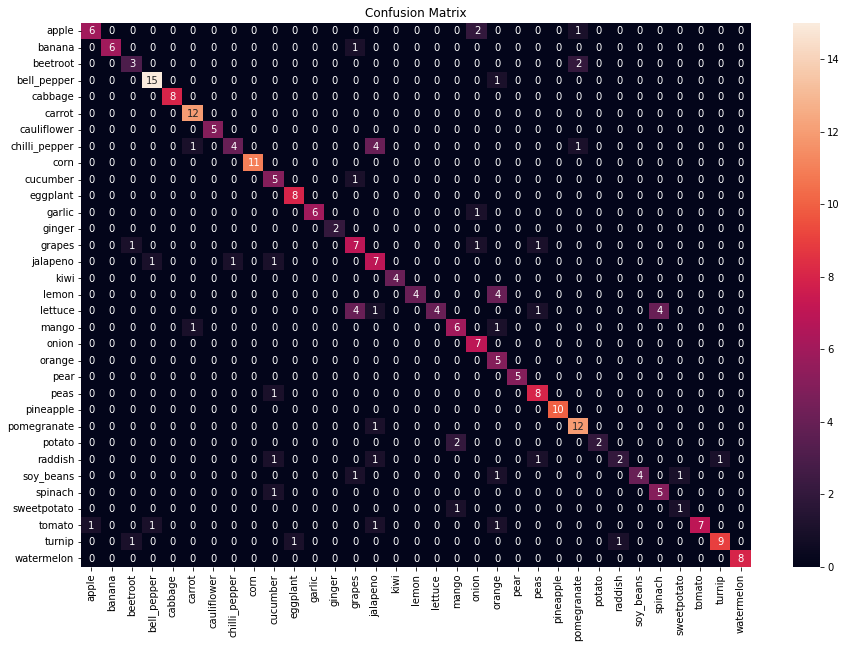

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model3b_ResNet50_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_3b_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 8.1874 - accuracy: 0.9185
Epoch 00001: val_loss improved from inf to 21.86363, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model3b_ResNet50_Fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 21s 308ms/step - loss: 8.1874 - accuracy: 0.9185 - val_loss: 21.8636 - val_accuracy: 0.8619
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 7.1820 - accuracy: 0.9231
Epoch 00002: val_loss did not improve from 21.86363
68/68 [==============================] - 19s 277ms/step - loss: 7.1820 - accuracy: 0.9231 - val_loss: 28.8423 - val_accuracy: 0.8619
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 8.4152 - accuracy: 0.9218
Epoch 00003: val_loss did not improve from 21.86363
68/68 [==============================] - 19s 276ms/step - loss: 8.4152 - accuracy: 0.9218 - val_loss: 28.8759 - val_accuracy: 0.8703
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 6.8059 - accuracy: 0.9311
Epoch 00004: val_loss did not improve from 21.86363
68/68 [==============================] - 19s 276ms/step - loss: 6.8059 - accuracy: 0.9311 - val_loss: 30.4370 - val_accuracy: 0.8577
Epoch 5/50
68/68 [============

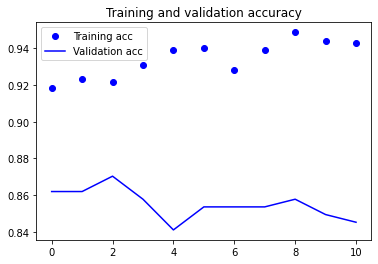

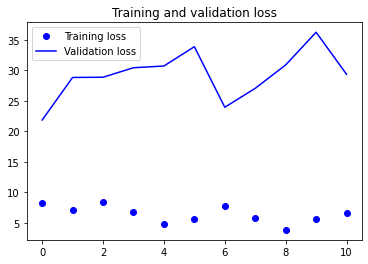

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_3b_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 197ms/step - loss: 36.0603 - accuracy: 0.8189


0.8188679218292236

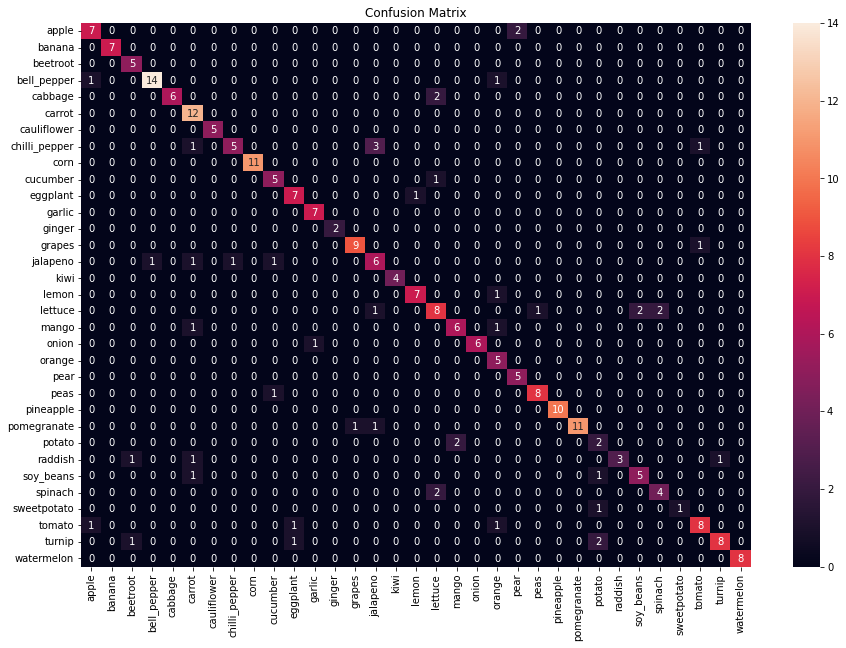

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_3b_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

###Model_4_RelL1L2

####Feature Extraction


In [ ]:
conv_base.trainable = False

In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=reg)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model_4_ResNet = keras.Model(inputs, outputs)
model_4_ResNet.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_ResNet50_feature_extraction.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 56.9065 - accuracy: 0.5366
Epoch 00001: val_loss improved from inf to 63.63480, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_ResNet50_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 28s 350ms/step - loss: 56.9065 - accuracy: 0.5366 - val_loss: 63.6348 - val_accuracy: 0.5900
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 22.8234 - accuracy: 0.7662
Epoch 00002: val_loss improved from 63.63480 to 27.95869, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_ResNet50_feature_extraction.h5
68/68 [==============================] - 23s 345ms/step - loss: 22.8234 - accuracy: 0.7662 - val_loss: 27.9587 - val_accuracy: 0.7615
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 19.0416 - accuracy: 0.8156
Epoch 00003: val_loss did not improve from 27.95869
68/68 [==============================] - 20s 291ms/step - loss: 19.0416 - accuracy: 0.8156 - val_loss: 60.2639 - val_accuracy: 0.6276
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 15.2503 - accuracy: 0.8496
Epoch 00004: val_loss improved from 27.95869 to 26.63736, saving model to /content/dri

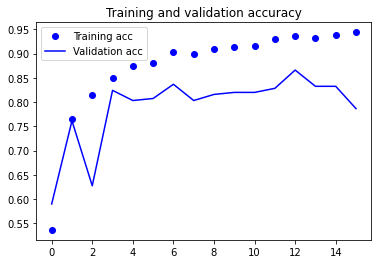

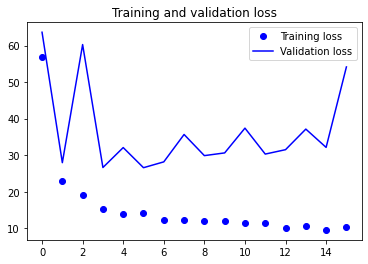

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 203ms/step - loss: 58.9868 - accuracy: 0.7585


0.7584905624389648

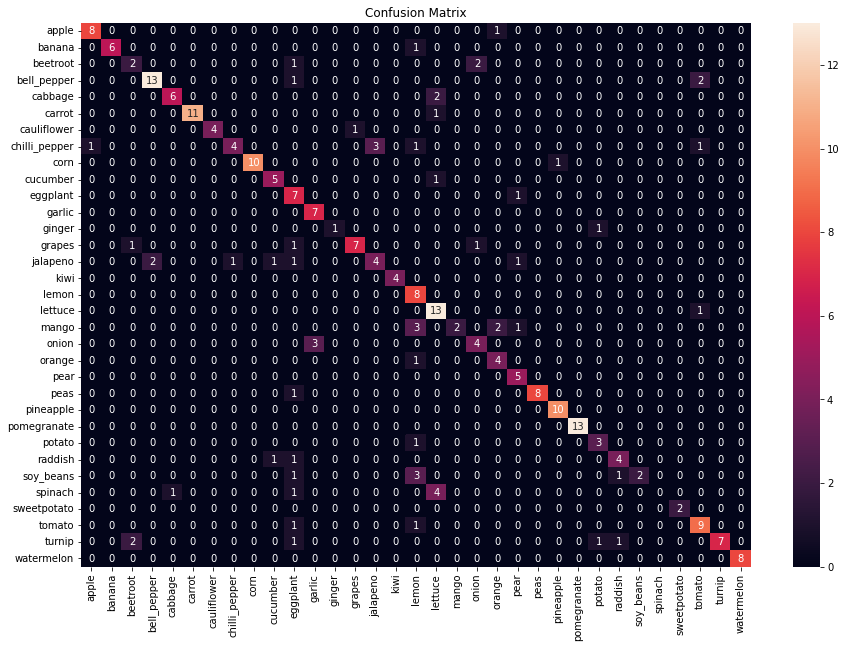

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()

####Fine-Tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,'CategoricalClassifier_Model4_ResNet50_Fine_tuning.h5')
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)

                  ]
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
history = model_4_ResNet.fit(
      training_set,
      labels_set_hot,
      epochs=50, 
      callbacks = [earlyStopping, callbacks_list],
      batch_size = BATCH_SIZE,
      validation_split = 0.1
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 9.8991 - accuracy: 0.9390
Epoch 00001: val_loss improved from inf to 37.35871, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_ResNet50_Fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 22s 321ms/step - loss: 9.8991 - accuracy: 0.9390 - val_loss: 37.3587 - val_accuracy: 0.8326
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 8.8984 - accuracy: 0.9469
Epoch 00002: val_loss did not improve from 37.35871
68/68 [==============================] - 20s 292ms/step - loss: 8.8984 - accuracy: 0.9469 - val_loss: 38.4923 - val_accuracy: 0.8201
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 8.9735 - accuracy: 0.9464
Epoch 00003: val_loss improved from 37.35871 to 36.69085, saving model to /content/drive/Shareddrives/CIDL//models/CategoricalClassifier_Model4_ResNet50_Fine_tuning.h5
68/68 [==============================] - 23s 346ms/step - loss: 8.9735 - accuracy: 0.9464 - val_loss: 36.6908 - val_accuracy: 0.8619
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 9.1143 - accuracy: 0.9469
Epoch 00004: val_loss improved from 36.69085 to 28.91758, saving model to /content/drive/Shareddriv

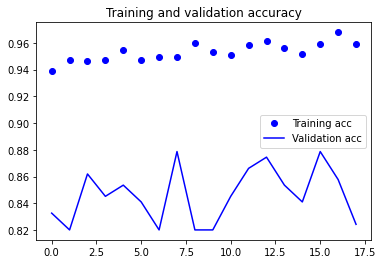

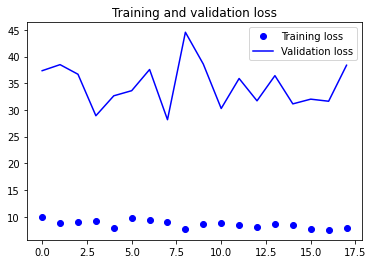

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model_4_ResNet.evaluate(test_set, test_labels_hot)
test_acc

9/9 [==============================] - 2s 203ms/step - loss: 38.4915 - accuracy: 0.8075


0.8075471520423889

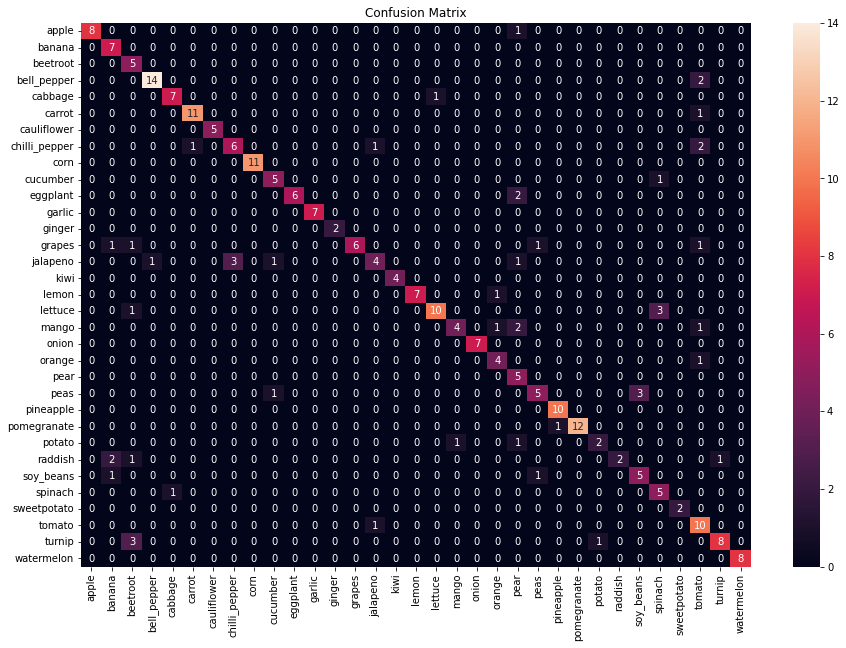

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=os.listdir(PATH_DATASET_PREPROCESSED)
labels = sorted(set(labels))

# Predict the label of the test_images
pred = model_4_ResNet.predict(test_set)
pred = np.argmax(pred,axis=1)

cf_matrix = confusion_matrix(test_labels, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )

plt.title('Confusion Matrix')
plt.show()